In [2]:
# Import all the necessary modules
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas_datareader as pdr
import math
import datetime
import itertools
import yfinance as yf
import seaborn as sn
from IPython.display import display, HTML
from trend_following_signal import (apply_jupyter_fullscreen_css, load_financial_data, get_returns_volatility, calculate_slope, trend_signal, slope_signal, 
                             create_trend_strategy, get_close_prices, calculate_donchian_channels)
from strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
import coinbase_utils as cn
import strategy_performance as perf
import position_sizing as size
import trend_following_signal as tf
%matplotlib inline

In [3]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size)

<module 'position_sizing' from '/Users/adheerchauhan/Documents/git/trend_following/position_sizing.py'>

In [4]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

In [5]:
# Target Volatility Position Sizing Strategy for a Trend Following Signal
def apply_target_volatility_position_sizing_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg,
                                                     mavg_stepsize, rolling_donchian_window, long_only=False,
                                                     initial_capital=15000, rolling_cov_window=20, volatility_window=20,
                                                     transaction_cost_est=0.001, passive_trade_rate=0.05,
                                                     use_coinbase_data=True, rolling_sharpe_window=50,
                                                     cash_buffer_percentage=0.10, annualized_target_volatility=0.20,
                                                     annual_trading_days=365, use_specific_start_date=False,
                                                     signal_start_date=None):
    ## Generate Trend Signal for all tickers
    df_trend = tf.get_trend_donchian_signal_for_portfolio(start_date=start_date, end_date=end_date,
                                                          ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                          slow_mavg=slow_mavg,
                                                          mavg_stepsize=mavg_stepsize,
                                                          rolling_donchian_window=rolling_donchian_window,
                                                          long_only=long_only, use_coinbase_data=use_coinbase_data)

    ## Get Volatility Adjusted Trend Signal
    df_signal = get_volatility_adjusted_trend_signal(df_trend, ticker_list, volatility_window, fast_mavg, mavg_stepsize,
                                                     slow_mavg, rolling_donchian_window, annual_trading_days)

    ## Get Daily Positions
    df = get_target_volatility_daily_portfolio_positions(df_signal, ticker_list, fast_mavg, slow_mavg, mavg_stepsize,
                                                         rolling_donchian_window, initial_capital, rolling_cov_window,
                                                         cash_buffer_percentage, annualized_target_volatility,
                                                         transaction_cost_est, passive_trade_rate, annual_trading_days,
                                                         use_specific_start_date, signal_start_date)

    ## Calculate Portfolio Performance
    df = calculate_portfolio_returns(df, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window,
                                     rolling_sharpe_window)

    return df

In [10]:
# Get Volatility Adjusted Trend Signal for Target Volatility Strategy
def get_volatility_adjusted_trend_signal(df, ticker_list, volatility_window, fast_mavg, mavg_stepsize, slow_mavg,
                                         rolling_donchian_window, annual_trading_days=365):
    ticker_signal_dict = {}
    final_cols = []
    for ticker in ticker_list:
        trend_signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
        # trend_returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
        # trend_trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'
        annualized_volatility_col = f'{ticker}_annualized_volatility_{volatility_window}'
        vol_adj_trend_signal_col = f'{ticker}_vol_adjusted_trend_signal'
        lower_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_price_t_2'
        upper_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_price_t_2'

        ## Calculate Position Volatility Adjusted Trend Signal
        df[f'{ticker}_t_1_close'] = df[f'{ticker}_close'].shift(1)
        df = tf.get_returns_volatility(df, vol_range_list=[volatility_window], close_px_col=f'{ticker}_t_1_close')
        df[annualized_volatility_col] = (df[f'{ticker}_t_1_close_volatility_{volatility_window}'] *
                                         np.sqrt(annual_trading_days))
        df[vol_adj_trend_signal_col] = (df[trend_signal_col] / df[annualized_volatility_col])
        df[vol_adj_trend_signal_col] = df[vol_adj_trend_signal_col].fillna(0)
        trend_cols = [f'{ticker}_close', f'{ticker}_open', f'{ticker}_t_1_close', f'{ticker}_t_1_close_pct_returns',
                      trend_signal_col, lower_donchian_col, upper_donchian_col, annualized_volatility_col,
                      vol_adj_trend_signal_col]
        final_cols.append(trend_cols)
        ticker_signal_dict[ticker] = df[trend_cols]
    df_signal = pd.concat(ticker_signal_dict, axis=1)

    ## Assign new column names to the dataframe
    df_signal.columns = df_signal.columns.to_flat_index()
    final_cols = [item for sublist in final_cols for item in sublist]
    df_signal.columns = final_cols

    ## Normalize the weights of each position by the total weight of the portfolio
    vol_normalized_signal_cols = [f'{ticker}_vol_adjusted_trend_signal' for ticker in ticker_list]
    df_signal[vol_normalized_signal_cols] = df_signal[vol_normalized_signal_cols].fillna(0)
    for ticker in ticker_list:
        df_signal[f'{ticker}_position_volatility_adjusted_weight'] = (df_signal[f'{ticker}_vol_adjusted_trend_signal'] /
                                                                      df_signal[vol_normalized_signal_cols].abs()
                                                                      .sum(axis=1))
        df_signal[f'{ticker}_position_volatility_adjusted_weight'] = df_signal[
            f'{ticker}_position_volatility_adjusted_weight'].fillna(0)

    return df_signal

In [12]:
def get_trend_donchian_signal_for_portfolio(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize,
                                            rolling_donchian_window, long_only=False, price_or_returns_calc='price',
                                            use_coinbase_data=True):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict
    for ticker in ticker_list:
        close_price_col = f'{ticker}_close'
        open_price_col = f'{ticker}_open'
        signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
        # returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
        # trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'
        lower_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'
        upper_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'
        if pd.to_datetime(date_list[ticker]).date() > start_date:
            df_trend = generate_trend_signal_with_donchian_channel(
                start_date=pd.to_datetime(date_list[ticker]).date(), end_date=end_date, ticker=ticker,
                fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                rolling_donchian_window=rolling_donchian_window, price_or_returns_calc=price_or_returns_calc,
                long_only=long_only, use_coinbase_data=use_coinbase_data)
        else:
            df_trend = generate_trend_signal_with_donchian_channel(
                start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
                price_or_returns_calc=price_or_returns_calc, long_only=long_only, use_coinbase_data=use_coinbase_data)
        trend_cols = [close_price_col, open_price_col, signal_col, lower_donchian_col, upper_donchian_col]#returns_col, trades_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

In [14]:
def generate_trend_signal_with_donchian_channel(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize,
                                                moving_avg_type='exponential', price_or_returns_calc='price',
                                                rolling_donchian_window=20, long_only=False, use_coinbase_data=True):
    # Create Column Names
    donchian_signal_col = f'{ticker}_{rolling_donchian_window}_donchian_signal'
    trend_signal_col = f'{ticker}_trend_signal'
    trend_donchian_signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
    strategy_returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
    strategy_trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'

    # Pull Close Prices from Coinbase
    df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                        end_date=end_date, save_to_file=False)
    df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
    df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]

    # Generate Trend Signal
    df_trend = (create_trend_strategy(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize,
                                      slope_window=10, moving_avg_type=moving_avg_type,
                                      price_or_returns_calc=price_or_returns_calc)
                .rename(columns={
        f'{ticker}_trend_strategy_returns': f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}',
        f'{ticker}_trend_strategy_trades': f'{ticker}_trend_strategy_trades_{fast_mavg}_{mavg_stepsize}_{slow_mavg}'}))

    # Generate Donchian Channels
    df_donchian = calculate_donchian_channels(start_date=start_date, end_date=end_date, ticker=ticker,
                                              price_or_returns_calc=price_or_returns_calc,
                                              rolling_donchian_window=rolling_donchian_window,
                                              use_coinbase_data=use_coinbase_data)

    # Donchian Buy signal: Price crosses above upper band
    # Donchian Sell signal: Price crosses below lower band
    df_donchian[f't_1_close'] = df_donchian[f'close'].shift(1)
    t_1_close_col = f't_1_close'
    donchian_upper_band_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}'
    donchian_lower_band_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}'
    donchian_middle_band_col = f'{ticker}_{rolling_donchian_window}_donchian_middle_band_{price_or_returns_calc}'
    df_donchian[f'{donchian_upper_band_col}_t_2'] = df_donchian[donchian_upper_band_col].shift(1)
    df_donchian[f'{donchian_lower_band_col}_t_2'] = df_donchian[donchian_lower_band_col].shift(1)
    df_donchian[f'{donchian_middle_band_col}_t_2'] = df_donchian[donchian_middle_band_col].shift(1)
    df_donchian[donchian_signal_col] = np.where(
        (df_donchian[t_1_close_col] > df_donchian[f'{donchian_upper_band_col}_t_2']), 1,
        np.where((df_donchian[t_1_close_col] < df_donchian[f'{donchian_lower_band_col}_t_2']),
                 -1, 0))

    # Merging the Trend and Donchian Dataframes
    donchian_cols = [f'{donchian_upper_band_col}_t_2', f'{donchian_lower_band_col}_t_2',
                     f'{donchian_middle_band_col}_t_2', donchian_signal_col]
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left')

    # Trend and Donchian Channel Signal
    buy_signal = ((df_trend[donchian_signal_col] == 1) &
                  (df_trend[trend_signal_col] == 1))
    sell_signal = ((df_trend[donchian_signal_col] == -1) &
                   (df_trend[trend_signal_col] == -1))

    # Generate Long Only Signal
    if long_only:
        df_trend[trend_donchian_signal_col] = np.where(buy_signal, 1, 0)
    # Generate Long & Short Signal
    else:
        df_trend[trend_donchian_signal_col] = np.where(buy_signal, 1, np.where(sell_signal, -1, 0))

    df_trend[strategy_returns_col] = df_trend[trend_donchian_signal_col] * df_trend[f'{ticker}_pct_returns']
    df_trend[strategy_trades_col] = df_trend[trend_donchian_signal_col].diff()

    return df_trend

In [52]:
# start_date = pd.to_datetime('2022-01-01').date()
# end_date = pd.to_datetime('2025-03-28').date()
start_date = pd.to_datetime('2016-01-01').date()
end_date = pd.to_datetime('2021-12-31').date()
ticker_list = ['BTC-USD']
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
long_only = True
use_coinbase_data = True
volatility_window = 20
annual_trading_days = 365
rolling_cov_window = 20
annualized_target_volatility = 0.70
use_specific_start_date = False
signal_start_date = None
initial_capital = 15000
cash_buffer_percentage = 0.10
transaction_cost_est = 0.001
passive_trade_rate = 0.05
rolling_sharpe_window = 50

In [28]:
## Generate Trend Signal for all tickers
df_trend = tf.get_trend_donchian_signal_for_portfolio(start_date=start_date, end_date=end_date,
                                                      ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                      slow_mavg=slow_mavg,
                                                      mavg_stepsize=mavg_stepsize,
                                                      rolling_donchian_window=rolling_donchian_window,
                                                      long_only=long_only, use_coinbase_data=use_coinbase_data)

## Get Volatility Adjusted Trend Signal
df_signal = get_volatility_adjusted_trend_signal(df_trend, ticker_list, volatility_window, fast_mavg, mavg_stepsize,
                                                 slow_mavg, rolling_donchian_window, annual_trading_days)

## Get Daily Positions
df = size.get_target_volatility_daily_portfolio_positions(df_signal, ticker_list, fast_mavg, slow_mavg, mavg_stepsize,
                                                     rolling_donchian_window, initial_capital, rolling_cov_window,
                                                     cash_buffer_percentage, annualized_target_volatility,
                                                     transaction_cost_est, passive_trade_rate, annual_trading_days,
                                                     use_specific_start_date, signal_start_date)

## Calculate Portfolio Performance
df = size.calculate_portfolio_returns(df, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window,
                                 rolling_sharpe_window)

In [23]:
perf.calculate_risk_and_performance_metrics(df, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='count_of_positions',
                                            include_transaction_costs_and_fees=False, annual_trading_days=365)

{'annualized_return': 0.41878125291384394,
 'annualized_sharpe_ratio': 1.4812871206778893,
 'calmar_ratio': 0.36069842660983703,
 'annualized_std_dev': 0.21870479637077,
 'max_drawdown': -1.1610287764488487,
 'max_drawdown_duration': Timedelta('547 days 00:00:00'),
 'hit_rate': 0.07218880148079593,
 't_statistic': 4.14714904425681,
 'p_value': 3.496594160349296e-05,
 'trade_count': 268.0}

In [19]:
df.tail()

BTC-USD_20_donchian_lower_band_price_t_2  \
date                                                   
2022-12-27                                  16439.74   
2022-12-28                                  16439.74   
2022-12-29                                  16439.74   
2022-12-30                                  16439.74   
2022-12-31                                  16439.74   

            BTC-USD_20_donchian_upper_band_price_t_2  \
date                                                   
2022-12-27                                  17804.97   
2022-12-28                                  17804.97   
2022-12-29                                  17804.97   
2022-12-30                                  17804.97   
2022-12-31                                  17804.97   

            BTC-USD_50_6_250_mavg_crossover_20_donchian_signal  \
date                                                             
2022-12-27                                                  0    
2022-12-28                                                  0    
2022-12-29                                                  0    
2022-12-30                                                  0    
2022-12-31                                                  0    

            BTC-USD_actual_position_entry_price  \
date                                              
2022-12-27                                  0.0   
2022-12-28                                  0.0   
2022-12-29                                  0.0   
2022-12-30                                  0.0   
2022-12-31                                  0.0   

            BTC-USD_actual_position_exit_price  \
date                                             
2022-12-27                                 0.0   
2022-12-28                                 0.0   
2022-12-29                                 0.0   
2022-12-30                                 0.0   
2022-12-31                                 0.0   

            BTC-USD_actual_position_notional  BTC-USD_actual_size  \
date                                                                
2022-12-27                               0.0                  0.0   
2022-12-28                               0.0                  0.0   
2022-12-29                               0.0                  0.0   
2022-12-30                               0.0                  0.0   
2022-12-31                               0.0                  0.0   

            BTC-USD_annualized_volatility_20  BTC-USD_close BTC-USD_event  \
date                                                                        
2022-12-27                          0.325700       16698.73      No Event   
2022-12-28                          0.324416       16539.66      No Event   
2022-12-29                          0.309080       16627.54      No Event   
2022-12-30                          0.310105       16600.10      No Event   
2022-12-31                          0.310058       16530.35      No Event   

            BTC-USD_open  BTC-USD_position_volatility_adjusted_weight  \
date                                                                    
2022-12-27      16916.66                                          0.0   
2022-12-28      16698.31                                          0.0   
2022-12-29      16539.66                                          0.0   
2022-12-30      16627.36                                          0.0   
2022-12-31      16599.98                                          0.0   

            BTC-USD_short_sale_proceeds  BTC-USD_stop_loss  BTC-USD_t_1_close  \
date                                                                            
2022-12-27                          0.0                0.0           16917.96   
2022-12-28                          0.0                0.0           16698.73   
2022-12-29                          0.0                0.0           16539.66   
2022-12-30                          0.0                0.0           16627.54   
2022-12-31                      

In [32]:
df.head()

BTC-USD_20_donchian_lower_band_price_t_2  \
date                                                   
2022-02-01                                  35066.43   
2022-02-02                                  35066.43   
2022-02-03                                  35066.43   
2022-02-04                                  35066.43   
2022-02-05                                  35066.43   

            BTC-USD_20_donchian_upper_band_price_t_2  \
date                                                   
2022-02-01                                  43920.37   
2022-02-02                                  43920.37   
2022-02-03                                  43104.34   
2022-02-04                                  43104.34   
2022-02-05                                  43104.34   

            BTC-USD_50_6_250_mavg_crossover_20_donchian_signal  \
date                                                             
2022-02-01                                                  0    
2022-02-02                                                  0    
2022-02-03                                                  0    
2022-02-04                                                  0    
2022-02-05                                                  0    

            BTC-USD_actual_position_entry_price  \
date                                              
2022-02-01                                  0.0   
2022-02-02                                  0.0   
2022-02-03                                  0.0   
2022-02-04                                  0.0   
2022-02-05                                  0.0   

            BTC-USD_actual_position_exit_price  \
date                                             
2022-02-01                                 0.0   
2022-02-02                                 0.0   
2022-02-03                                 0.0   
2022-02-04                                 0.0   
2022-02-05                                 0.0   

            BTC-USD_actual_position_notional  BTC-USD_actual_size  \
date                                                                
2022-02-01                               0.0                  0.0   
2022-02-02                               0.0                  0.0   
2022-02-03                               0.0                  0.0   
2022-02-04                               0.0                  0.0   
2022-02-05                               0.0                  0.0   

            BTC-USD_annualized_volatility_20  BTC-USD_close BTC-USD_event  \
date                                                                        
2022-02-01                          0.571326       38716.88             0   
2022-02-02                          0.555307       36923.39      No Event   
2022-02-03                          0.572651       37329.91      No Event   
2022-02-04                          0.572075       41614.64      No Event   
2022-02-05                          0.772829       41404.85      No Event   

            BTC-USD_open  BTC-USD_position_volatility_adjusted_weight  \
date                                                                    
2022-02-01      38492.53                                          0.0   
2022-02-02      38714.27                                          0.0   
2022-02-03      36923.39                                          0.0   
2022-02-04      37324.61                                          0.0   
2022-02-05      41613.75                                          0.0   

            BTC-USD_short_sale_proceeds  BTC-USD_stop_loss  BTC-USD_t_1_close  \
date                                                                            
2022-02-01                          0.0                0.0           38491.93   
2022-02-02                          0.0                0.0           38716.88   
2022-02-03                          0.0                0.0           36923.39   
2022-02-04                          0.0                0.0           37329.91   
2022-02-05                      

In [191]:
from strategy_performance import calculate_risk_and_performance_metrics

import seaborn as sns

def plot_moving_avg_crossover_performance_heatmap(df_performance):
    unique_step_sizes = df_performance['stepsize'].unique()

    # Plotting each heatmap in a loop
    for step in unique_step_sizes:
        subset = df_performance[df_performance['stepsize'] == step]
        pivoted_df_sharpe = subset.pivot(index='slow_mavg', columns='fast_mavg', values='sharpe_ratio')
        pivoted_df_calmar = subset.pivot(index='slow_mavg', columns='fast_mavg', values='calmar_ratio')
        pivoted_df_return = subset.pivot(index='slow_mavg', columns='fast_mavg', values='annualized_return')
        
        fig = plt.figure(figsize=(30,6))
        # plt.style.use('bmh')
        layout = (1,3)
        sharpe_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
        calmar_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
        return_ax = plt.subplot2grid(layout, (0,2))#, colspan=2)

        sns.heatmap(pivoted_df_sharpe, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=sharpe_ax)
        _ = sharpe_ax.set_title(f'Sharpe Ratio Heatmap\nStep Size: {step}')
        _ = sharpe_ax.set_ylabel('Slow Moving Average (Days)')
        _ = sharpe_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_calmar, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=calmar_ax)
        _ = calmar_ax.set_title(f'Calmar Ratio Heatmap\nStep Size: {step}')
        _ = calmar_ax.set_ylabel('Slow Moving Average (Days)')
        _ = calmar_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_return, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=return_ax)
        _ = return_ax.set_title(f'Annualized Return Heatmap\nStep Size: {step}')
        _ = return_ax.set_ylabel('Slow Moving Average (Days)')
        _ = return_ax.set_xlabel('Fast Moving Average (Days)')

        plt.tight_layout()
    
    return

def moving_avg_crossover_strategy_performance(start_date, end_date, ticker_list, fast_mavg_list=np.arange(10, 101, 10), slow_mavg_list=np.arange(50, 501, 50), rolling_donchian_window=20, long_only=True,
                                              initial_capital=15000, rolling_cov_window=20, volatility_window=20, transaction_cost_est=0.001, passive_trade_rate=0.05, use_coinbase_data=True,
                                              rolling_sharpe_window=50, cash_buffer_percentage=0.10, annualized_target_volatility=0.20, annual_trading_days=365, use_specific_start_date=False,
                                              signal_start_date=None):
    
    perf_cols = ['fast_mavg', 'slow_mavg', 'stepsize', 'annualized_return', 'sharpe_ratio', 'calmar_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration',
                'hit_rate', 't_statistic', 'p_value', 'trade_count']
    df_performance = pd.DataFrame(columns=perf_cols)
    
    mavg_stepsize_list = [2, 4, 6, 8]
    for slow_mavg in slow_mavg_list:
        for fast_mavg in fast_mavg_list:
            for stepsize in mavg_stepsize_list:
                if fast_mavg < slow_mavg:
                    df = size.apply_target_volatility_position_sizing_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg,
                                                                               mavg_stepsize, rolling_donchian_window, long_only, initial_capital,
                                                                               rolling_cov_window, volatility_window, transaction_cost_est, passive_trade_rate,
                                                                               use_coinbase_data, rolling_sharpe_window, cash_buffer_percentage, annualized_target_volatility,
                                                                               annual_trading_days, use_specific_start_date, signal_start_date)
                    performance_metrics = calculate_risk_and_performance_metrics(df, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                                passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
                    row = {
                        # 'ticker': ticker,
                        'fast_mavg': fast_mavg,
                        'slow_mavg': slow_mavg,
                        'stepsize': stepsize,
                        'annualized_return': performance_metrics['annualized_return'],
                        'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
                        'calmar_ratio': performance_metrics['calmar_ratio'],
                        'annualized_std_dev': performance_metrics['annualized_std_dev'],
                        'max_drawdown': performance_metrics['max_drawdown'],
                        'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
                        'hit_rate': performance_metrics['hit_rate'],
                        't_statistic': performance_metrics['t_statistic'],
                        'p_value': performance_metrics['p_value'],
                        'trade_count': performance_metrics['trade_count']
                    }
                    df_performance = pd.concat([df_performance, pd.DataFrame([row])], ignore_index=True)
    
    return df_performance

In [185]:
def plot_trend_following_performance_time_series(df, df_trend, start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, price_or_returns_calc, rolling_donchian_window, rolling_sharpe_window):
    
    start_date = pd.to_datetime(start_date).date().strftime('%Y-%m-%d')
    end_date = pd.to_datetime(end_date).date().strftime('%Y-%m-%d')
    fig = plt.figure(figsize=(22,20))
    layout = (5,2)
    trend_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    trend_donchian_ax = plt.subplot2grid(layout, (1,0), colspan=2)
    trend_signal_ax = plt.subplot2grid(layout, (2,0), colspan=2)
    trend_signal_ax2 = trend_signal_ax.twinx()
    trend_rolling_sharpe_ax = plt.subplot2grid(layout, (3,0), colspan=2)
    trend_return_ax = plt.subplot2grid(layout, (4,0))#, colspan=2)
    trend_cum_return_ax = plt.subplot2grid(layout, (4,1))#, colspan=2)

    _ = trend_ax.plot(df.index, df[f'{ticker}_t_1_close'], label='Price')
    for mavg in np.linspace(fast_mavg, slow_mavg, mavg_stepsize):
        _ = trend_ax.plot(df_trend.index, df_trend[f'{ticker}_{int(mavg)}_mavg'], label=f'{mavg} M Avg')

    _ = trend_ax.set_title(f'{ticker} Moving Average Ribbons - {start_date} - {end_date}')
    _ = trend_ax.set_ylabel('Price')
    _ = trend_ax.set_xlabel('Date')
    _ = trend_ax.legend(loc='upper left')
    _ = trend_ax.grid()

    _ = trend_donchian_ax.plot(df.index, df[f'{ticker}_t_1_close'], label='Price')
    _ = trend_donchian_ax.plot(df.index,
                      df[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'], label='Donchian Upper Band', linestyle='--', linewidth=3)
    _ = trend_donchian_ax.plot(df.index,
                      df[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'], label='Donchian Lower Band', linestyle='--', linewidth=3)

    _ = trend_donchian_ax.set_title(f'{ticker} Donchian Channels')
    _ = trend_donchian_ax.set_ylabel('Price')
    _ = trend_donchian_ax.set_xlabel('Date')
    _ = trend_donchian_ax.legend(loc='upper left')
    _ = trend_donchian_ax.grid()

    _ = trend_signal_ax.plot(df.index,
                             df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'], label='Signal')
    _ = trend_signal_ax2.plot(df.index, df[f'{ticker}_t_1_close'], label='Price', alpha=0.8, color='orange', linestyle='--')
    _ = trend_signal_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Signal')
    _ = trend_signal_ax.set_ylabel('Signal')
    _ = trend_signal_ax.set_xlabel('Date')
    _ = trend_signal_ax.legend(loc='upper left')
    _ = trend_signal_ax.grid()

    _ = trend_rolling_sharpe_ax.plot(df.index, df[f'portfolio_rolling_sharpe_50'],
                                     # df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_rolling_sharpe_{rolling_sharpe_window}'],
                                     label='Sharpe Ratio', color='orange')
    _ = trend_rolling_sharpe_ax.set_title(f'{ticker} Rolling Sharpe Ratio')
    _ = trend_rolling_sharpe_ax.set_ylabel('Sharpe Ratio')
    _ = trend_rolling_sharpe_ax.set_xlabel('Date')
    _ = trend_rolling_sharpe_ax.legend(loc='upper left')
    _ = trend_rolling_sharpe_ax.grid()

    _ = trend_return_ax.plot(df.index, df[f'portfolio_daily_pct_returns'],
                             # df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'],
                             label='Return')
    _ = trend_return_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Return')
    _ = trend_return_ax.set_ylabel('Return')
    _ = trend_return_ax.set_xlabel('Date')
    _ = trend_return_ax.legend(loc='upper left')
    _ = trend_return_ax.grid()

    # _ = trend_cum_return_ax.plot(df_trend_mavg_donchian.index, df_trend_mavg_donchian[f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_cum'], label='Cum. Return')
    _ = trend_cum_return_ax.plot(df.index, df['strategy_cumulative_return'], label='Cum. Return')
    _ = trend_cum_return_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Cumulative Return')
    _ = trend_cum_return_ax.set_ylabel('Cum. Return')
    _ = trend_cum_return_ax.set_xlabel('Date')
    _ = trend_cum_return_ax.legend(loc='upper left')
    _ = trend_cum_return_ax.grid()


    plt.tight_layout()
    
    return

In [154]:
df.head()

BTC-USD_10_6_100_mavg_crossover_20_donchian_signal  \
date                                                             
2016-02-01                                                  0    
2016-02-02                                                  0    
2016-02-03                                                  0    
2016-02-04                                                  0    
2016-02-05                                                  0    

            BTC-USD_20_donchian_lower_band_price_t_2  \
date                                                   
2016-02-01                                    357.53   
2016-02-02                                    357.53   
2016-02-03                                    357.53   
2016-02-04                                    357.53   
2016-02-05                                    357.53   

            BTC-USD_20_donchian_upper_band_price_t_2  \
date                                                   
2016-02-01                                    449.19   
2016-02-02                                    434.01   
2016-02-03                                    432.77   
2016-02-04                                    430.03   
2016-02-05                                    418.54   

            BTC-USD_actual_position_entry_price  \
date                                              
2016-02-01                                  0.0   
2016-02-02                                  0.0   
2016-02-03                                  0.0   
2016-02-04                                  0.0   
2016-02-05                                  0.0   

            BTC-USD_actual_position_exit_price  \
date                                             
2016-02-01                                 0.0   
2016-02-02                                 0.0   
2016-02-03                                 0.0   
2016-02-04                                 0.0   
2016-02-05                                 0.0   

            BTC-USD_actual_position_notional  BTC-USD_actual_size  \
date                                                                
2016-02-01                               0.0                  0.0   
2016-02-02                               0.0                  0.0   
2016-02-03                               0.0                  0.0   
2016-02-04                               0.0                  0.0   
2016-02-05                               0.0                  0.0   

            BTC-USD_annualized_volatility_20  BTC-USD_close BTC-USD_event  \
date                                                                        
2016-02-01                          1.076237         371.33             0   
2016-02-02                          1.072386         372.93      No Event   
2016-02-03                          1.073254         368.87      No Event   
2016-02-04                          1.073469         387.99      No Event   
2016-02-05                          0.814133         384.50      No Event   

            BTC-USD_open  BTC-USD_position_volatility_adjusted_weight  \
date                                                                    
2016-02-01        367.89                                          0.0   
2016-02-02        371.33                                          0.0   
2016-02-03        372.93                                          0.0   
2016-02-04        368.87                                          0.0   
2016-02-05        387.99                                          0.0   

            BTC-USD_short_sale_proceeds  BTC-USD_stop_loss  BTC-USD_t_1_close  \
date                                                                            
2016-02-01                          0.0                0.0             367.95   
2016-02-02                          0.0                0.0             371.33   
2016-02-03                          0.0                0.0             372.93   
2016-02-04                          0.0                0.0             368.87   
2016-02-05                      

In [166]:
df_trend.head()

BTC-USD_close  BTC-USD_open  BTC-USD_pct_returns  BTC-USD_10_mavg  \
date                                                                            
2016-01-11         449.19        449.99            -0.001778       446.322330   
2016-01-12         434.01        449.26            -0.033794       443.862349   
2016-01-13         432.77        434.01            -0.002857       441.685262   
2016-01-14         430.03        432.70            -0.006331       439.430279   
2016-01-15         357.53        430.04            -0.168593       423.767312   

            BTC-USD_10_mavg_slope  BTC-USD_28_mavg  BTC-USD_28_mavg_slope  \
date                                                                        
2016-01-11               1.066233       443.789053               0.812905   
2016-01-12               0.834535       442.617746               0.709239   
2016-01-13               0.761825       441.495247               0.726208   
2016-01-14               0.543476       440.244677               0.611780   
2016-01-15              -1.004002       431.570502              -0.237575   

            BTC-USD_46_mavg  BTC-USD_46_mavg_slope  BTC-USD_64_mavg  \
date                                                                  
2016-01-11       443.170270               0.751027       442.895987   
2016-01-12       442.211500               0.668433       442.021708   
2016-01-13       441.281086               0.701243       441.169098   
2016-01-14       440.231134               0.607407       440.201925   
2016-01-15       432.886336              -0.109281       433.404810   

            BTC-USD_64_mavg_slope  BTC-USD_82_mavg  BTC-USD_82_mavg_slope  \
date                                                                        
2016-01-11               0.723599       442.741531               0.708153   
2016-01-12               0.649374       441.912382               0.638397   
2016-01-13               0.688500       441.101669               0.680893   
2016-01-14               0.603149       440.179431               0.600146   
2016-01-15              -0.058900       433.679762              -0.032234   

            BTC-USD_100_mavg  BTC-USD_100_mavg_slope  \
date                                                   
2016-01-11        442.642526                0.698253   
2016-01-12        441.841409                0.631271   
2016-01-13        441.056836                0.675857   
2016-01-14        440.162764                0.597995   
2016-01-15        433.849645               -0.015780   

            BTC-USD_ribbon_thickness  BTC-USD_trend_signal  \
date                                                         
2016-01-11                  3.673250                   1.0   
2016-01-12                  3.679804                   1.0   
2016-01-13                  2.020940                   1.0   
2016-01-14                  0.628426                   1.0   
2016-01-15                 -0.732485                   0.0   

            BTC-USD_trend_strategy_returns_10_6_100  \
date                                                  
2016-01-11                                -0.001778   
2016-01-12                                -0.033794   
2016-01-13                                -0.002857   
2016-01-14                                -0.006331   
2016-01-15                                -0.000000   

            BTC-USD_trend_strategy_trades_10_6_100  \
date                                                 
2016-01-11                                     0.0   
2016-01-12                                     0.0   
2016-01-13                                     0.0   
2016-01-14                                     0.0   
2016-01-15                                    -1.0   

            BTC-USD_trend_slope_signal  BTC-USD_trend_slope_strategy_returns  \
date                                                                           
2016-01-11                         0.0                             -0.000000   
2016-01-12                       

In [193]:
count = 0
# fast_mavg_list = np.arange(5, 101, 5)
# slow_mavg_list = np.arange(10, 301, 10)
fast_mavg_list = np.arange(5, 51, 5)
slow_mavg_list = np.arange(10, 101, 10)
mavg_stepsize_list = [2, 4, 6, 8]
for slow_mavg in slow_mavg_list:
    for fast_mavg in fast_mavg_list:
        for stepsize in mavg_stepsize_list:
            if fast_mavg < slow_mavg:
                print(fast_mavg, stepsize, slow_mavg)
                count+=1

5 2 10
5 4 10
5 6 10
5 8 10
5 2 20
5 4 20
5 6 20
5 8 20
10 2 20
10 4 20
10 6 20
10 8 20
15 2 20
15 4 20
15 6 20
15 8 20
5 2 30
5 4 30
5 6 30
5 8 30
10 2 30
10 4 30
10 6 30
10 8 30
15 2 30
15 4 30
15 6 30
15 8 30
20 2 30
20 4 30
20 6 30
20 8 30
25 2 30
25 4 30
25 6 30
25 8 30
5 2 40
5 4 40
5 6 40
5 8 40
10 2 40
10 4 40
10 6 40
10 8 40
15 2 40
15 4 40
15 6 40
15 8 40
20 2 40
20 4 40
20 6 40
20 8 40
25 2 40
25 4 40
25 6 40
25 8 40
30 2 40
30 4 40
30 6 40
30 8 40
35 2 40
35 4 40
35 6 40
35 8 40
5 2 50
5 4 50
5 6 50
5 8 50
10 2 50
10 4 50
10 6 50
10 8 50
15 2 50
15 4 50
15 6 50
15 8 50
20 2 50
20 4 50
20 6 50
20 8 50
25 2 50
25 4 50
25 6 50
25 8 50
30 2 50
30 4 50
30 6 50
30 8 50
35 2 50
35 4 50
35 6 50
35 8 50
40 2 50
40 4 50
40 6 50
40 8 50
45 2 50
45 4 50
45 6 50
45 8 50
5 2 60
5 4 60
5 6 60
5 8 60
10 2 60
10 4 60
10 6 60
10 8 60
15 2 60
15 4 60
15 6 60
15 8 60
20 2 60
20 4 60
20 6 60
20 8 60
25 2 60
25 4 60
25 6 60
25 8 60
30 2 60
30 4 60
30 6 60
30 8 60
35 2 60
35 4 60
35 6 60
35 8 60


In [195]:
count

300

In [239]:
start_date = pd.to_datetime('2016-01-01').date()
end_date = pd.to_datetime('2022-12-31').date()
ticker_list = ['BTC-USD']
fast_mavg = 35
slow_mavg = 60
mavg_stepsize = 6
rolling_donchian_window = 20
long_only = True
use_coinbase_data = True
volatility_window = 20
annual_trading_days = 365
rolling_cov_window = 20
annualized_target_volatility = 0.70
use_specific_start_date = False
signal_start_date = None
initial_capital = 15000
cash_buffer_percentage = 0.10
transaction_cost_est = 0.001#0.0025
passive_trade_rate = 0.05
rolling_sharpe_window = 50
price_or_returns_calc = 'price'

In [343]:
def generate_trend_signal_with_donchian_channel_macro(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize,
                                                moving_avg_type='exponential', price_or_returns_calc='price',
                                                rolling_donchian_window=20, long_only=False, use_coinbase_data=True):
    # Create Column Names
    donchian_signal_col = f'{ticker}_{rolling_donchian_window}_donchian_signal'
    trend_signal_col = f'{ticker}_trend_signal'
    trend_donchian_signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
    strategy_returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
    strategy_trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'

    # Pull Close Prices from Coinbase
    df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                        end_date=end_date, save_to_file=False)
    df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
    df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]

    # Generate Trend Signal
    df_trend = (create_trend_strategy(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize,
                                      slope_window=10, moving_avg_type=moving_avg_type,
                                      price_or_returns_calc=price_or_returns_calc)
                .rename(columns={
                    f'{ticker}_trend_strategy_returns': f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}',
                    f'{ticker}_trend_strategy_trades': f'{ticker}_trend_strategy_trades_{fast_mavg}_{mavg_stepsize}_{slow_mavg}'}))

    # Generate Donchian Channels
    df_donchian = calculate_donchian_channels(start_date=start_date, end_date=end_date, ticker=ticker,
                                              price_or_returns_calc=price_or_returns_calc,
                                              rolling_donchian_window=rolling_donchian_window,
                                              use_coinbase_data=use_coinbase_data)

    # Donchian Buy signal: Price crosses above upper band
    # Donchian Sell signal: Price crosses below lower band
    df_donchian[f't_1_close'] = df_donchian[f'close'].shift(1)
    t_1_close_col = f't_1_close'
    donchian_upper_band_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}'
    donchian_lower_band_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}'
    donchian_middle_band_col = f'{ticker}_{rolling_donchian_window}_donchian_middle_band_{price_or_returns_calc}'
    df_donchian[f'{donchian_upper_band_col}_t_2'] = df_donchian[donchian_upper_band_col].shift(1)
    df_donchian[f'{donchian_lower_band_col}_t_2'] = df_donchian[donchian_lower_band_col].shift(1)
    df_donchian[f'{donchian_middle_band_col}_t_2'] = df_donchian[donchian_middle_band_col].shift(1)
    df_donchian[donchian_signal_col] = np.where(
        (df_donchian[t_1_close_col] > df_donchian[f'{donchian_upper_band_col}_t_2']), 1,
        np.where((df_donchian[t_1_close_col] < df_donchian[f'{donchian_lower_band_col}_t_2']),
                 -1, 0))

    # Merging the Trend and Donchian Dataframes
    donchian_cols = [f'{donchian_upper_band_col}_t_2', f'{donchian_lower_band_col}_t_2',
                     f'{donchian_middle_band_col}_t_2', donchian_signal_col]
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left')

    # Macro Trend Signal
    t_1_close_col = f'{ticker}_t_1_close'
    df_trend[t_1_close_col] = df_trend[f'{ticker}_close'].shift(1)
    simple_macro_signal_col = f'{ticker}_simple_macro_signal'
    exp_macro_signal_col = f'{ticker}_exp_macro_signal'
    df_trend[f'{ticker}_200d_mavg_macro_simple'] = df_trend[t_1_close_col].rolling(window=100).mean()
    df_trend[f'{ticker}_200d_mavg_macro_exp'] = df_trend[t_1_close_col].ewm(span=100).mean()
    df_trend[simple_macro_signal_col] = np.where(df_trend[t_1_close_col] > df_trend[f'{ticker}_200d_mavg_macro_simple'], 1,
                                                 np.where(df_trend[t_1_close_col] < df_trend[f'{ticker}_200d_mavg_macro_simple'], -1, 0))
    df_trend[exp_macro_signal_col] = np.where(df_trend[t_1_close_col] > df_trend[f'{ticker}_200d_mavg_macro_exp'], 1,
                                              np.where(df_trend[t_1_close_col] < df_trend[f'{ticker}_200d_mavg_macro_exp'], -1, 0))

    # Trend and Donchian Channel Signal
    buy_signal = ((df_trend[donchian_signal_col] == 1) &
                  (df_trend[trend_signal_col] == 1) &
                  (df_trend[exp_macro_signal_col] == 1))
    sell_signal = ((df_trend[donchian_signal_col] == -1) &
                   (df_trend[trend_signal_col] == -1) &
                   (df_trend[exp_macro_signal_col] == -1))

    # Generate Long Only Signal
    if long_only:
        df_trend[trend_donchian_signal_col] = np.where(buy_signal, 1, 0)
    # Generate Long & Short Signal
    else:
        df_trend[trend_donchian_signal_col] = np.where(buy_signal, 1, np.where(sell_signal, -1, 0))

    df_trend[strategy_returns_col] = df_trend[trend_donchian_signal_col] * df_trend[f'{ticker}_pct_returns']
    df_trend[strategy_trades_col] = df_trend[trend_donchian_signal_col].diff()

    return df_trend


def get_trend_donchian_signal_for_portfolio_macro(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize,
                                            rolling_donchian_window, long_only=False, price_or_returns_calc='price',
                                            use_coinbase_data=True):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict
    for ticker in ticker_list:
        close_price_col = f'{ticker}_close'
        open_price_col = f'{ticker}_open'
        signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
        # returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
        # trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'
        lower_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'
        upper_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'
        if pd.to_datetime(date_list[ticker]).date() > start_date:
            df_trend = generate_trend_signal_with_donchian_channel_macro(
                start_date=pd.to_datetime(date_list[ticker]).date(), end_date=end_date, ticker=ticker,
                fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                rolling_donchian_window=rolling_donchian_window, price_or_returns_calc=price_or_returns_calc,
                long_only=long_only, use_coinbase_data=use_coinbase_data)
        else:
            df_trend = generate_trend_signal_with_donchian_channel_macro(
                start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
                price_or_returns_calc=price_or_returns_calc, long_only=long_only, use_coinbase_data=use_coinbase_data)
        trend_cols = [close_price_col, open_price_col, signal_col, lower_donchian_col, upper_donchian_col]#returns_col, trades_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

In [295]:
df_trend.head()

BTC-USD_close  BTC-USD_open  BTC-USD_pct_returns  BTC-USD_35_mavg  \
date                                                                            
2016-01-11         449.19        449.99            -0.001778       443.474492   
2016-01-12         434.01        449.26            -0.033794       442.415178   
2016-01-13         432.77        434.01            -0.002857       441.393247   
2016-01-14         430.03        432.70            -0.006331       440.247046   
2016-01-15         357.53        430.04            -0.168593       432.265142   

            BTC-USD_35_mavg_slope  BTC-USD_40_mavg  BTC-USD_40_mavg_slope  \
date                                                                        
2016-01-11               0.781449       443.315818               0.765582   
2016-01-12               0.688889       442.309867               0.678312   
2016-01-13               0.714191       441.336363               0.707596   
2016-01-14               0.610480       440.240943               0.609096   
2016-01-15              -0.169781       432.595264              -0.137612   

            BTC-USD_45_mavg  BTC-USD_45_mavg_slope  BTC-USD_50_mavg  \
date                                                                  
2016-01-11       443.191869               0.753187       443.092417   
2016-01-12       442.226203               0.669909       442.158208   
2016-01-13       441.289473               0.702204       441.250326   
2016-01-14       440.232842               0.607683       440.224257   
2016-01-15       432.843845              -0.113415       433.037466   

            BTC-USD_50_mavg_slope  BTC-USD_55_mavg  BTC-USD_55_mavg_slope  \
date                                                                        
2016-01-11               0.743242       443.010877               0.735088   
2016-01-12               0.663081       442.101896               0.657426   
2016-01-13               0.697727       441.217231               0.693958   
2016-01-14               0.606340       440.215848               0.605101   
2016-01-15              -0.094583       433.192373              -0.079528   

            BTC-USD_60_mavg  BTC-USD_60_mavg_slope  BTC-USD_ribbon_thickness  \
date                                                                           
2016-01-11       442.942824               0.728282                  0.506441   
2016-01-12       442.054515               0.652668                  0.531669   
2016-01-13       441.188931               0.690746                  0.360663   
2016-01-14       440.207892               0.603974                  0.204316   
2016-01-15       433.319027              -0.067227                  0.039154   

            BTC-USD_trend_signal  BTC-USD_trend_strategy_returns_35_6_60  \
date                                                                       
2016-01-11                   1.0                               -0.001778   
2016-01-12                   1.0                               -0.033794   
2016-01-13                   1.0                               -0.002857   
2016-01-14                   1.0                               -0.006331   
2016-01-15                   1.0                               -0.168593   

            BTC-USD_trend_strategy_trades_35_6_60  BTC-USD_trend_slope_signal  \
date                                                                            
2016-01-11                                    0.0                         0.0   
2016-01-12                                    0.0                         1.0   
2016-01-13                                    0.0                         1.0   
2016-01-14                                    0.0                         1.0   
2016-01-15                                    0.0                         1.0   

            BTC-USD_trend_slope_strategy_returns  \
date                                               
2016-01-11                             -0.000000   
2016-01-12                             -0.033794

In [345]:
def apply_target_volatility_position_sizing_strategy_macro(start_date, end_date, ticker_list, fast_mavg, slow_mavg,
                                                     mavg_stepsize, rolling_donchian_window, long_only=False,
                                                     initial_capital=15000, rolling_cov_window=20, volatility_window=20,
                                                     transaction_cost_est=0.001, passive_trade_rate=0.05,
                                                     use_coinbase_data=True, rolling_sharpe_window=50,
                                                     cash_buffer_percentage=0.10, annualized_target_volatility=0.20,
                                                     annual_trading_days=365, use_specific_start_date=False,
                                                     signal_start_date=None):
    ## Generate Trend Signal for all tickers
    df_trend = get_trend_donchian_signal_for_portfolio_macro(start_date=start_date, end_date=end_date,
                                                          ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                          slow_mavg=slow_mavg,
                                                          mavg_stepsize=mavg_stepsize,
                                                          rolling_donchian_window=rolling_donchian_window,
                                                          long_only=long_only, use_coinbase_data=use_coinbase_data)

    ## Get Volatility Adjusted Trend Signal
    df_signal = size.get_volatility_adjusted_trend_signal(df_trend, ticker_list, volatility_window, fast_mavg, mavg_stepsize,
                                                     slow_mavg, rolling_donchian_window, annual_trading_days)

    ## Get Daily Positions
    df = size.get_target_volatility_daily_portfolio_positions(df_signal, ticker_list, fast_mavg, slow_mavg, mavg_stepsize,
                                                         rolling_donchian_window, initial_capital, rolling_cov_window,
                                                         cash_buffer_percentage, annualized_target_volatility,
                                                         transaction_cost_est, passive_trade_rate, annual_trading_days,
                                                         use_specific_start_date, signal_start_date)

    ## Calculate Portfolio Performance
    df = size.calculate_portfolio_returns(df, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window,
                                          rolling_sharpe_window)

    return df

In [347]:
df = apply_target_volatility_position_sizing_strategy_macro(start_date, end_date, ticker_list, fast_mavg, slow_mavg,
                                                           mavg_stepsize, rolling_donchian_window, long_only, initial_capital,
                                                           rolling_cov_window, volatility_window, transaction_cost_est, passive_trade_rate,
                                                           use_coinbase_data, rolling_sharpe_window, cash_buffer_percentage, annualized_target_volatility,
                                                           annual_trading_days, use_specific_start_date, signal_start_date)
df_trend = generate_trend_signal_with_donchian_channel_macro(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize,
                                                          moving_avg_type='exponential', price_or_returns_calc='price',
                                                          rolling_donchian_window=20, long_only=False, use_coinbase_data=True)
performance_metrics = calculate_risk_and_performance_metrics(df, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                            strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                            passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

In [303]:
df_trend.head()

BTC-USD_close  BTC-USD_open  BTC-USD_pct_returns  BTC-USD_35_mavg  \
date                                                                            
2016-01-11         449.19        449.99            -0.001778       443.474492   
2016-01-12         434.01        449.26            -0.033794       442.415178   
2016-01-13         432.77        434.01            -0.002857       441.393247   
2016-01-14         430.03        432.70            -0.006331       440.247046   
2016-01-15         357.53        430.04            -0.168593       432.265142   

            BTC-USD_35_mavg_slope  BTC-USD_40_mavg  BTC-USD_40_mavg_slope  \
date                                                                        
2016-01-11               0.781449       443.315818               0.765582   
2016-01-12               0.688889       442.309867               0.678312   
2016-01-13               0.714191       441.336363               0.707596   
2016-01-14               0.610480       440.240943               0.609096   
2016-01-15              -0.169781       432.595264              -0.137612   

            BTC-USD_45_mavg  BTC-USD_45_mavg_slope  BTC-USD_50_mavg  \
date                                                                  
2016-01-11       443.191869               0.753187       443.092417   
2016-01-12       442.226203               0.669909       442.158208   
2016-01-13       441.289473               0.702204       441.250326   
2016-01-14       440.232842               0.607683       440.224257   
2016-01-15       432.843845              -0.113415       433.037466   

            BTC-USD_50_mavg_slope  BTC-USD_55_mavg  BTC-USD_55_mavg_slope  \
date                                                                        
2016-01-11               0.743242       443.010877               0.735088   
2016-01-12               0.663081       442.101896               0.657426   
2016-01-13               0.697727       441.217231               0.693958   
2016-01-14               0.606340       440.215848               0.605101   
2016-01-15              -0.094583       433.192373              -0.079528   

            BTC-USD_60_mavg  BTC-USD_60_mavg_slope  BTC-USD_ribbon_thickness  \
date                                                                           
2016-01-11       442.942824               0.728282                  0.506441   
2016-01-12       442.054515               0.652668                  0.531669   
2016-01-13       441.188931               0.690746                  0.360663   
2016-01-14       440.207892               0.603974                  0.204316   
2016-01-15       433.319027              -0.067227                  0.039154   

            BTC-USD_trend_signal  BTC-USD_trend_strategy_returns_35_6_60  \
date                                                                       
2016-01-11                   1.0                               -0.001778   
2016-01-12                   1.0                               -0.033794   
2016-01-13                   1.0                               -0.002857   
2016-01-14                   1.0                               -0.006331   
2016-01-15                   1.0                               -0.168593   

            BTC-USD_trend_strategy_trades_35_6_60  BTC-USD_trend_slope_signal  \
date                                                                            
2016-01-11                                    0.0                         0.0   
2016-01-12                                    0.0                         1.0   
2016-01-13                                    0.0                         1.0   
2016-01-14                                    0.0                         1.0   
2016-01-15                                    0.0                         1.0   

            BTC-USD_trend_slope_strategy_returns  \
date                                               
2016-01-11                             -0.000000   
2016-01-12                             -0.033794

In [305]:
df.tail()

BTC-USD_20_donchian_lower_band_price_t_2  \
date                                                   
2022-12-27                                  16439.74   
2022-12-28                                  16439.74   
2022-12-29                                  16439.74   
2022-12-30                                  16439.74   
2022-12-31                                  16439.74   

            BTC-USD_20_donchian_upper_band_price_t_2  \
date                                                   
2022-12-27                                  17804.97   
2022-12-28                                  17804.97   
2022-12-29                                  17804.97   
2022-12-30                                  17804.97   
2022-12-31                                  17804.97   

            BTC-USD_35_6_60_mavg_crossover_20_donchian_signal  \
date                                                            
2022-12-27                                                  0   
2022-12-28                                                  0   
2022-12-29                                                  0   
2022-12-30                                                  0   
2022-12-31                                                  0   

            BTC-USD_actual_position_entry_price  \
date                                              
2022-12-27                                  0.0   
2022-12-28                                  0.0   
2022-12-29                                  0.0   
2022-12-30                                  0.0   
2022-12-31                                  0.0   

            BTC-USD_actual_position_exit_price  \
date                                             
2022-12-27                                 0.0   
2022-12-28                                 0.0   
2022-12-29                                 0.0   
2022-12-30                                 0.0   
2022-12-31                                 0.0   

            BTC-USD_actual_position_notional  BTC-USD_actual_size  \
date                                                                
2022-12-27                               0.0                  0.0   
2022-12-28                               0.0                  0.0   
2022-12-29                               0.0                  0.0   
2022-12-30                               0.0                  0.0   
2022-12-31                               0.0                  0.0   

            BTC-USD_annualized_volatility_20  BTC-USD_close BTC-USD_event  \
date                                                                        
2022-12-27                          0.325700       16698.73      No Event   
2022-12-28                          0.324416       16539.66      No Event   
2022-12-29                          0.309080       16627.54      No Event   
2022-12-30                          0.310105       16600.10      No Event   
2022-12-31                          0.310058       16530.35      No Event   

            BTC-USD_open  BTC-USD_position_volatility_adjusted_weight  \
date                                                                    
2022-12-27      16916.66                                          0.0   
2022-12-28      16698.31                                          0.0   
2022-12-29      16539.66                                          0.0   
2022-12-30      16627.36                                          0.0   
2022-12-31      16599.98                                          0.0   

            BTC-USD_short_sale_proceeds  BTC-USD_stop_loss  BTC-USD_t_1_close  \
date                                                                            
2022-12-27                          0.0                0.0           16917.96   
2022-12-28                          0.0                0.0           16698.73   
2022-12-29                          0.0                0.0           16539.66   
2022-12-30                          0.0                0.0           16627.54   
2022-12-31                          0.0

In [244]:
performance_metrics

{'annualized_return': 0.4072296982799757,
 'annualized_sharpe_ratio': 1.4294117923174463,
 'calmar_ratio': 0.36298358128732094,
 'annualized_std_dev': 0.2212017268920184,
 'max_drawdown': -1.121895642871052,
 'max_drawdown_duration': Timedelta('721 days 00:00:00'),
 'hit_rate': 0.06690419635787807,
 't_statistic': 4.3406314743516985,
 'p_value': 1.4766825739191315e-05,
 'trade_count': 292.0}

In [322]:
## With Macro with 200d Simple Mavg
performance_metrics

{'annualized_return': 0.3472898377429454,
 'annualized_sharpe_ratio': 1.329157927828936,
 'calmar_ratio': 0.0526223671821473,
 'annualized_std_dev': 0.20231990432078212,
 'max_drawdown': -6.599662013319066,
 'max_drawdown_duration': Timedelta('721 days 00:00:00'),
 'hit_rate': 0.06096595407759303,
 't_statistic': 4.131050510221861,
 'p_value': 3.7285419813621617e-05,
 'trade_count': 267.0}

In [340]:
## With Macro with 200d Exp Mavg
performance_metrics

{'annualized_return': 0.3765453837819783,
 'annualized_sharpe_ratio': 1.378581894386259,
 'calmar_ratio': 0.33563316354305295,
 'annualized_std_dev': 0.21205515778476694,
 'max_drawdown': -1.121895642871052,
 'max_drawdown_duration': Timedelta('721 days 00:00:00'),
 'hit_rate': 0.0665083135391924,
 't_statistic': 4.231943109416562,
 'p_value': 2.3995108215966742e-05,
 'trade_count': 291.0}

In [330]:
## With Macro with 100d Simple Mavg
performance_metrics

{'annualized_return': 0.424938405374653,
 'annualized_sharpe_ratio': 1.4883785052757181,
 'calmar_ratio': 0.3563554767021332,
 'annualized_std_dev': 0.22078679598284492,
 'max_drawdown': -1.192456502443054,
 'max_drawdown_duration': Timedelta('721 days 00:00:00'),
 'hit_rate': 0.0665083135391924,
 't_statistic': 4.4968453693300985,
 'p_value': 7.208516122098651e-06,
 'trade_count': 287.0}

In [348]:
## With Macro with 100d Exp Mavg
performance_metrics

{'annualized_return': 0.4072296982799757,
 'annualized_sharpe_ratio': 1.4294117923174463,
 'calmar_ratio': 0.36298358128732094,
 'annualized_std_dev': 0.2212017268920184,
 'max_drawdown': -1.121895642871052,
 'max_drawdown_duration': Timedelta('721 days 00:00:00'),
 'hit_rate': 0.06690419635787807,
 't_statistic': 4.3406314743516985,
 'p_value': 1.4766825739191315e-05,
 'trade_count': 292.0}

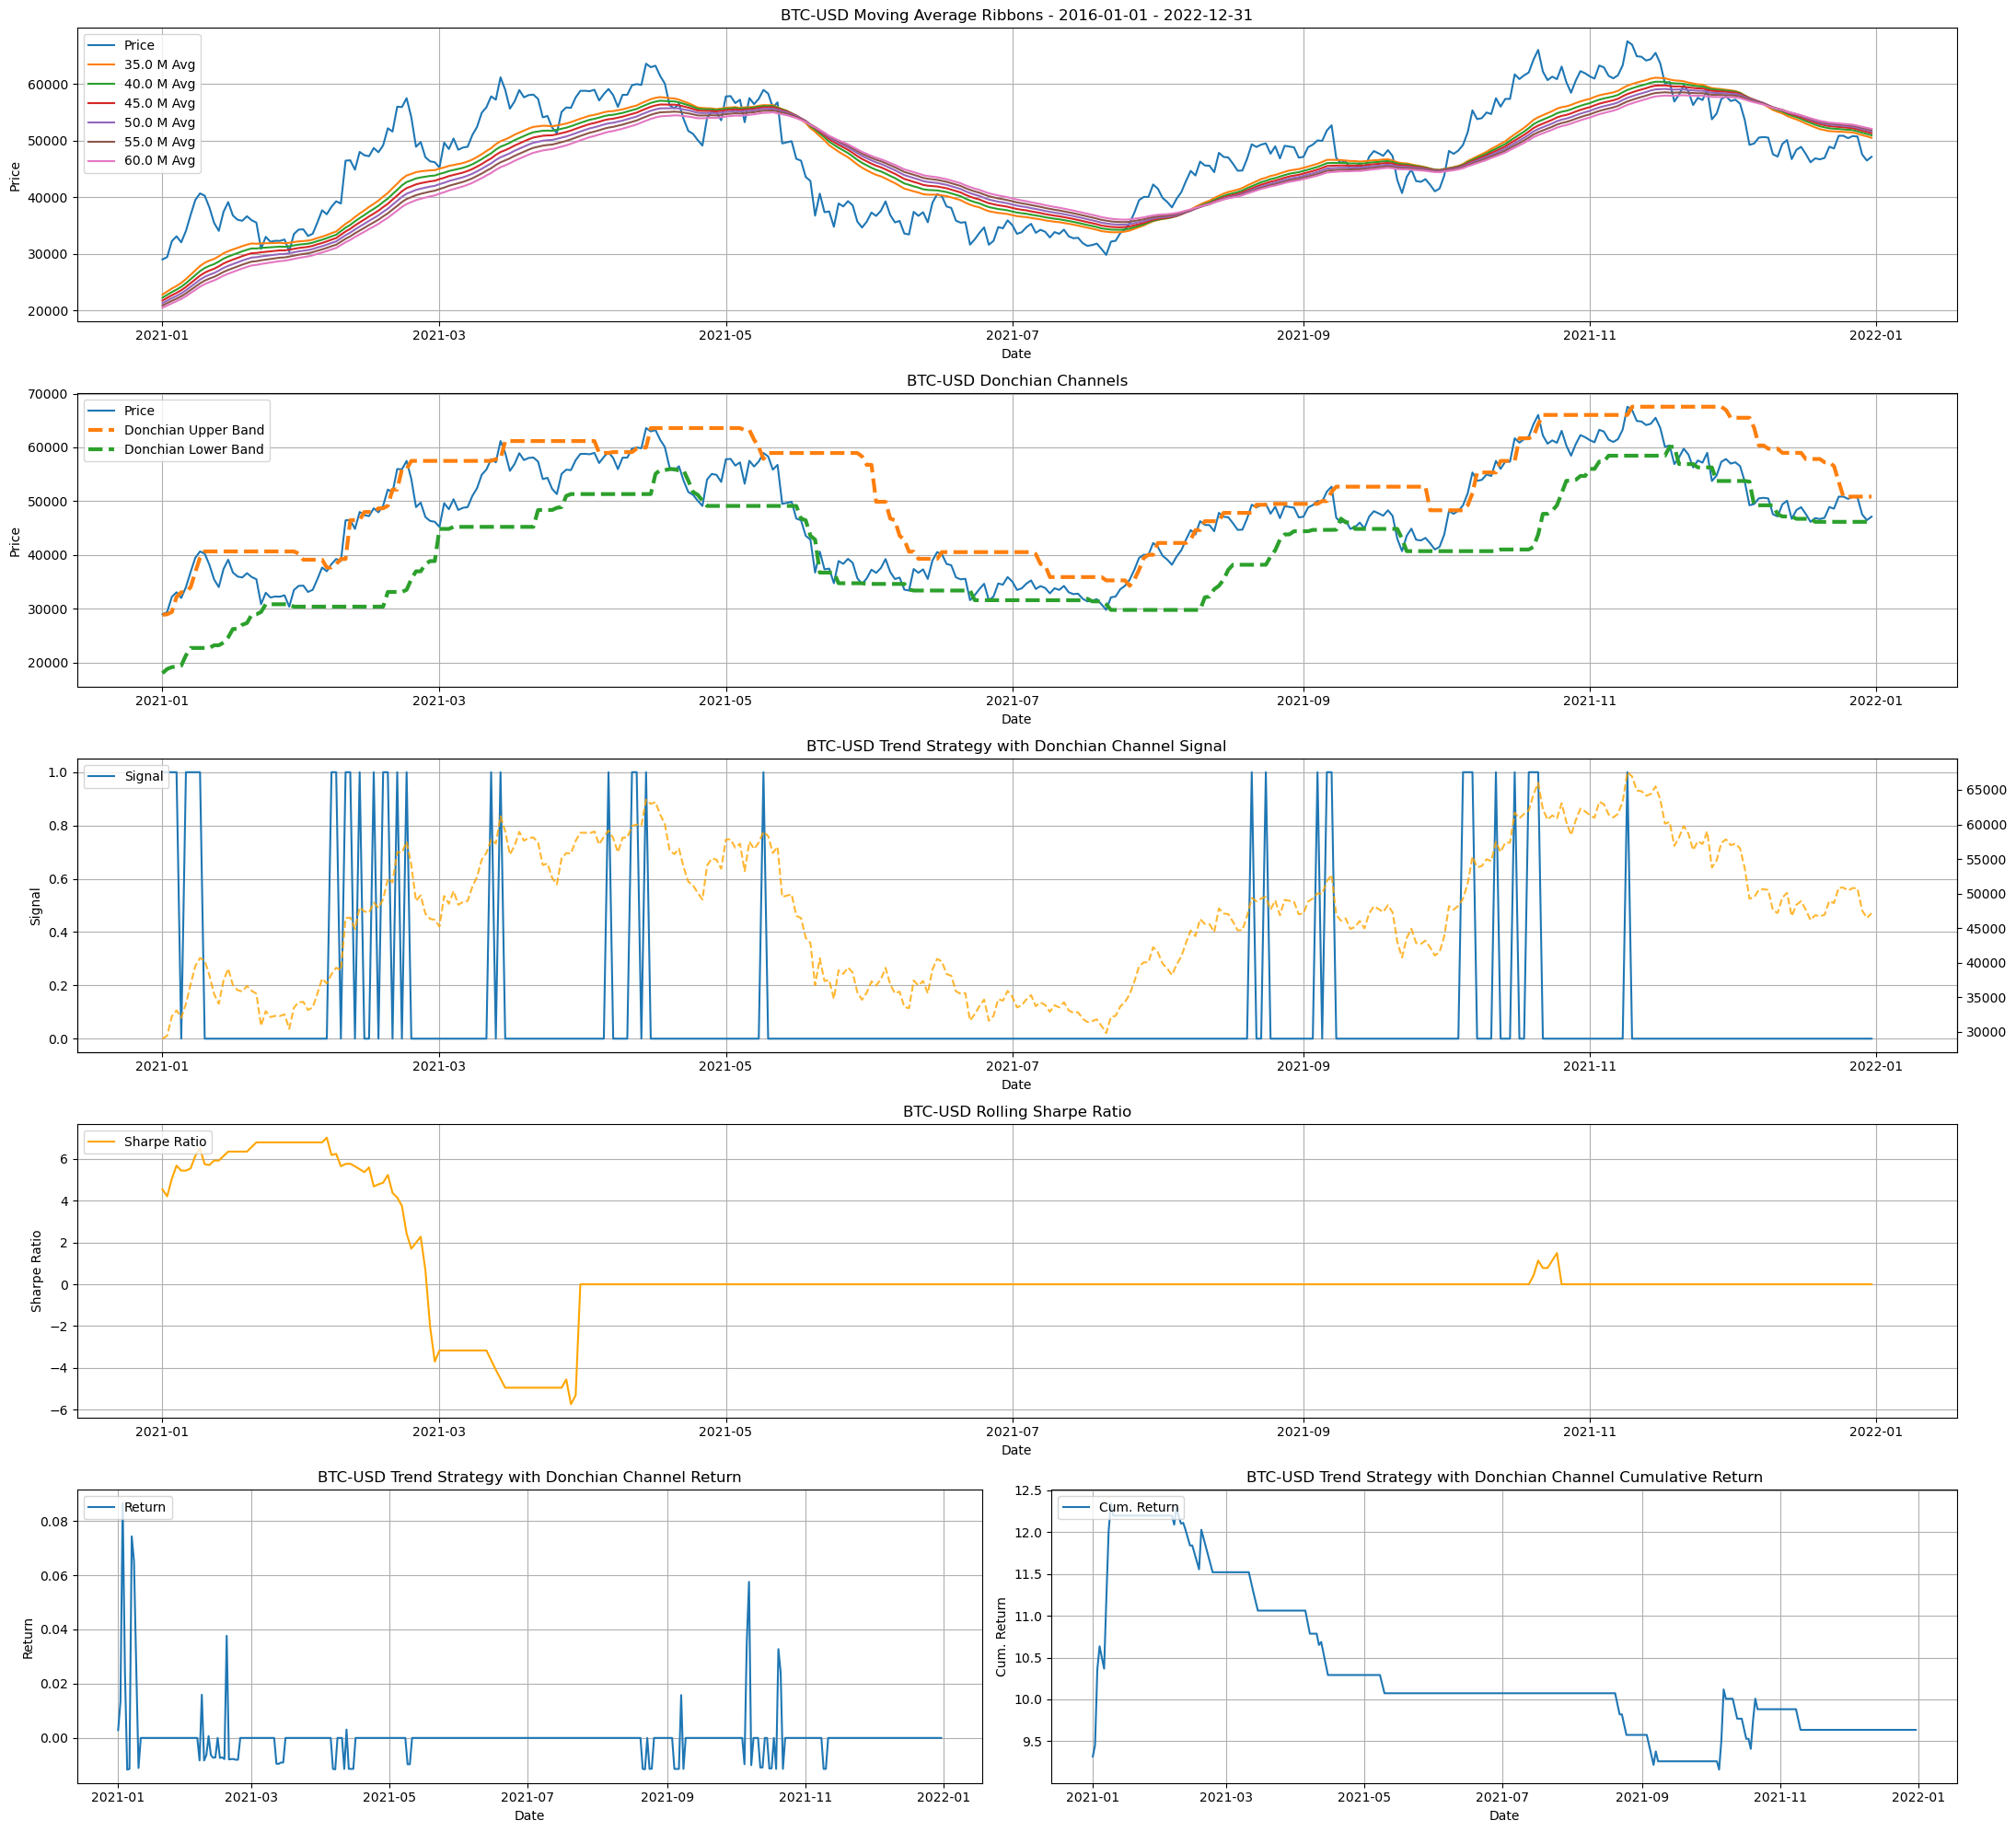

In [263]:
ticker = ticker_list[0]
df_date_cond = (df.index >= pd.Timestamp('2021-01-01').date()) & (df.index <= pd.Timestamp('2021-12-31').date())
df_trend_date_cond = (df_trend.index >= pd.Timestamp('2021-01-01').date()) & (df_trend.index <= pd.Timestamp('2021-12-31').date())
                
plot_trend_following_performance_time_series(df[df_date_cond], df_trend[df_trend_date_cond], start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, price_or_returns_calc, rolling_donchian_window, 
                                             rolling_sharpe_window)

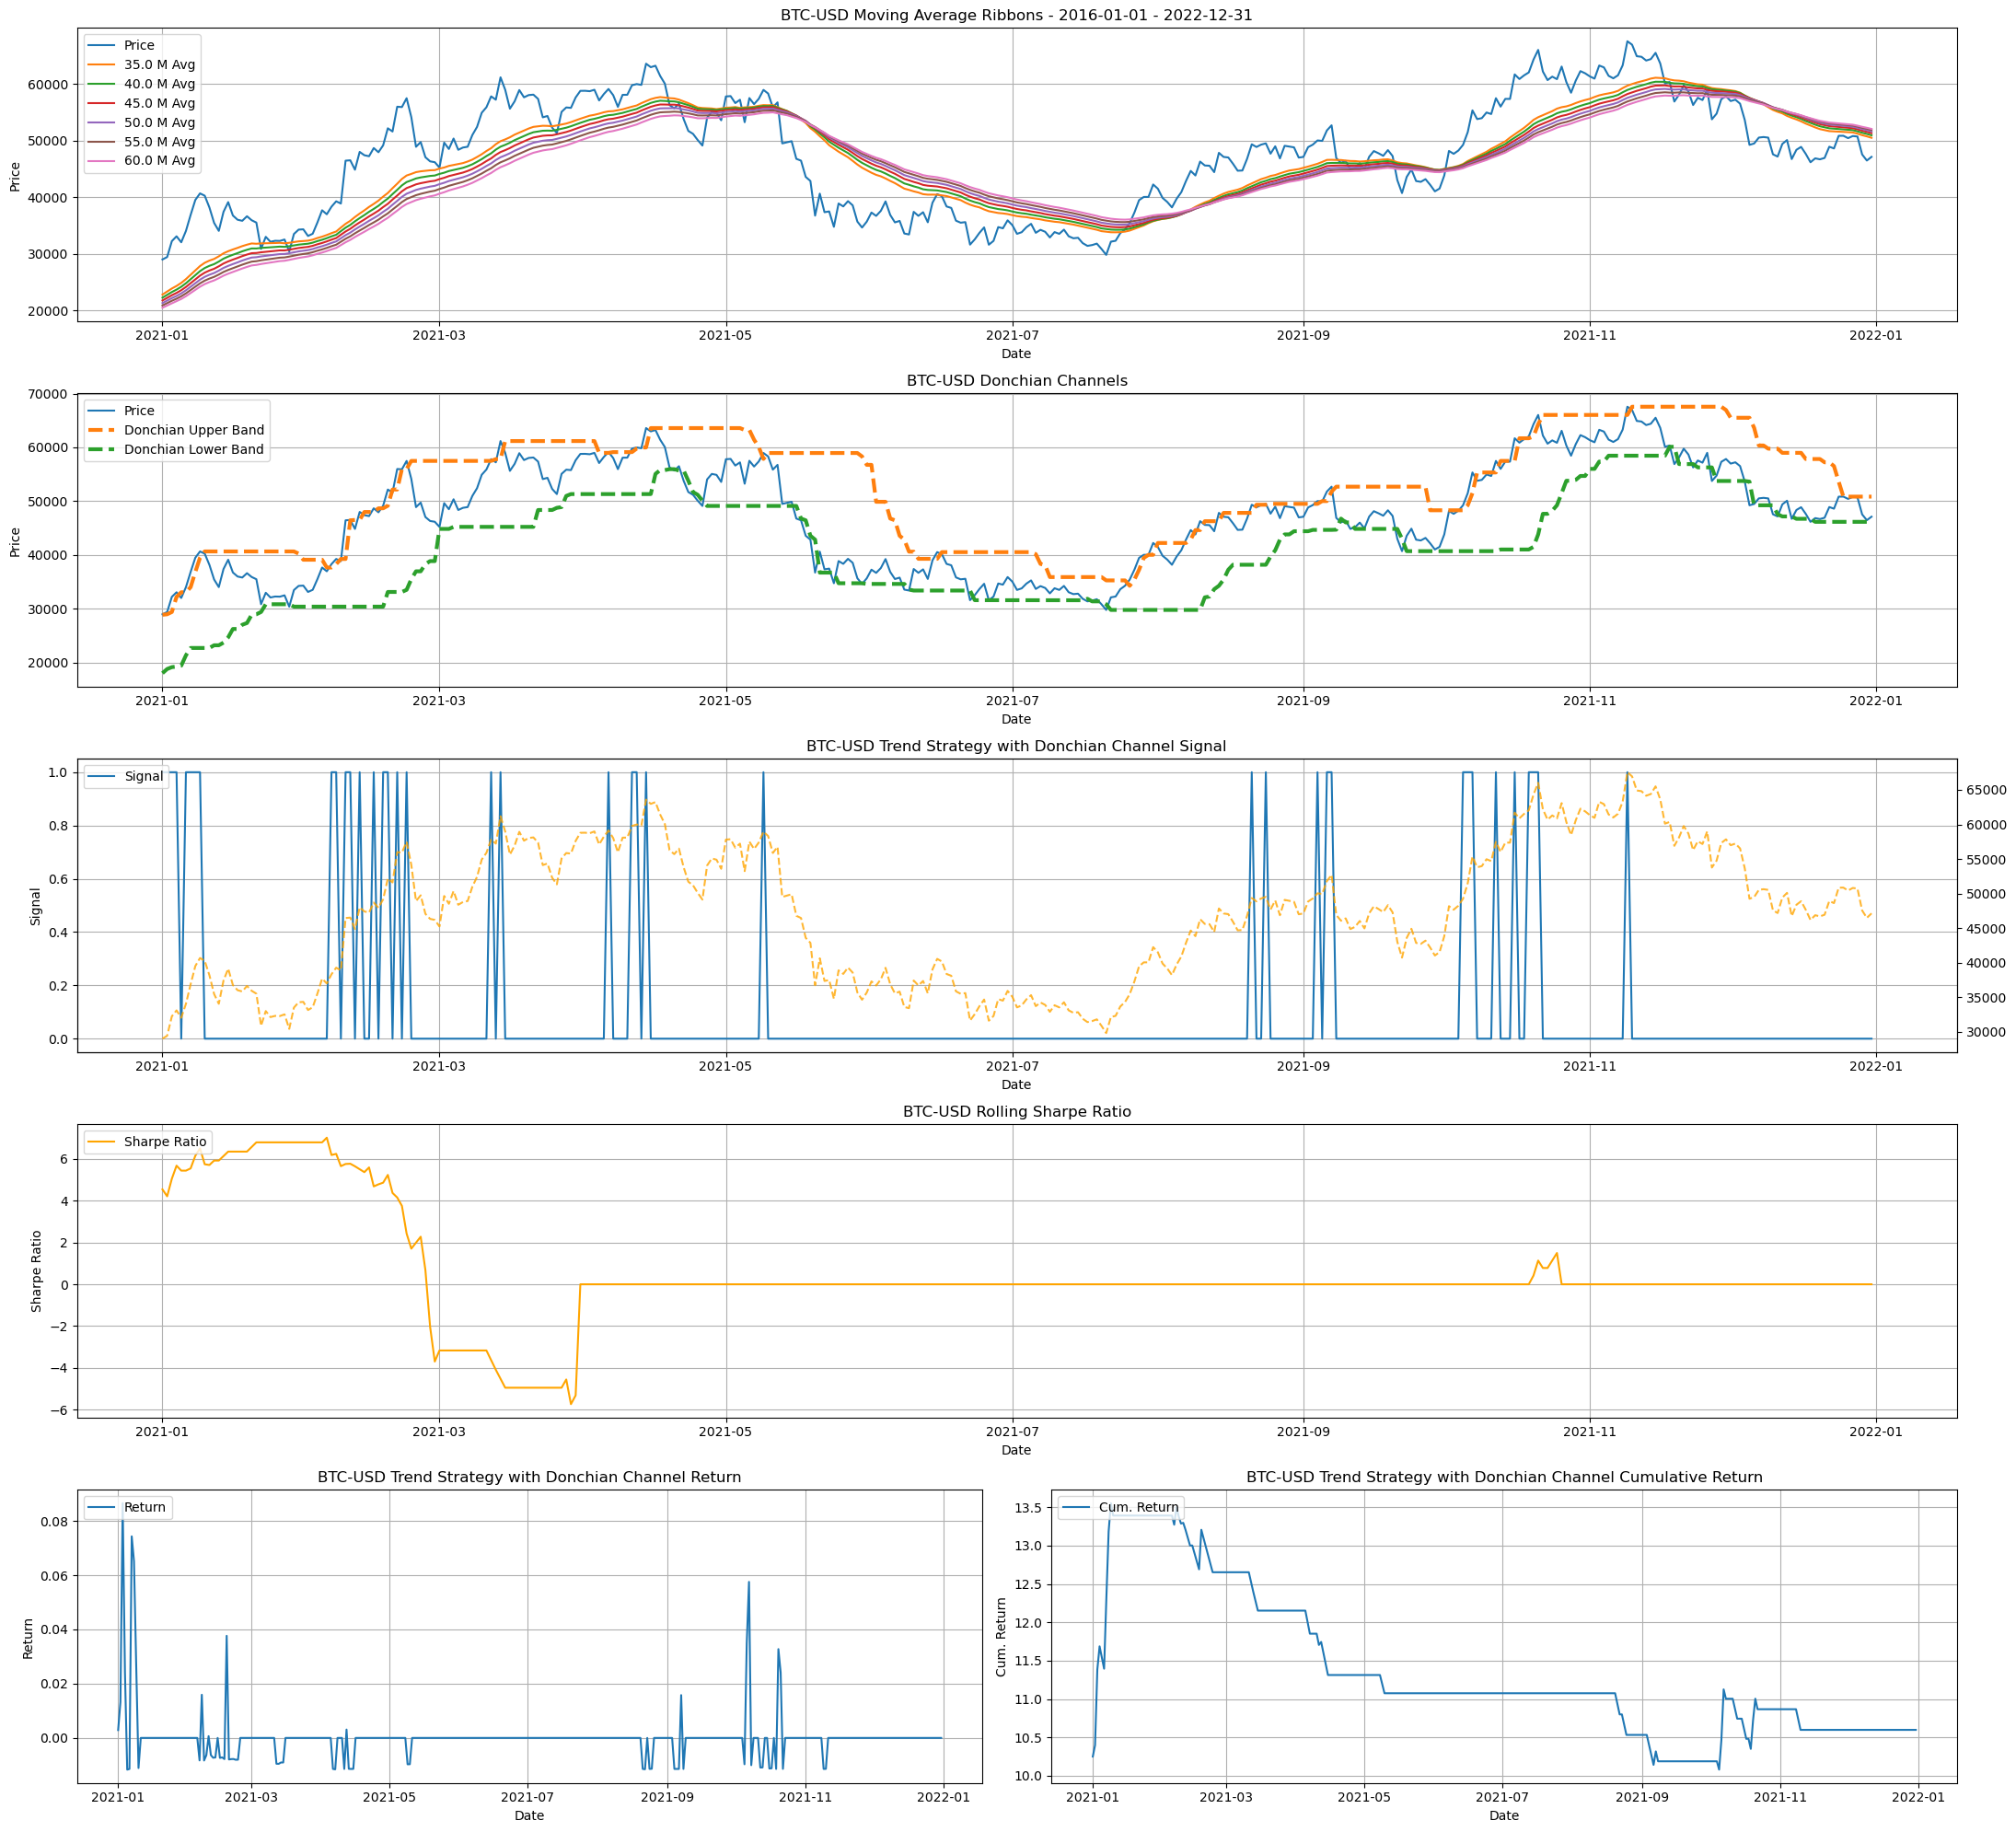

In [333]:
ticker = ticker_list[0]
df_date_cond = (df.index >= pd.Timestamp('2021-01-01').date()) & (df.index <= pd.Timestamp('2021-12-31').date())
df_trend_date_cond = (df_trend.index >= pd.Timestamp('2021-01-01').date()) & (df_trend.index <= pd.Timestamp('2021-12-31').date())
                
plot_trend_following_performance_time_series(df[df_date_cond], df_trend[df_trend_date_cond], start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, price_or_returns_calc, rolling_donchian_window, 
                                             rolling_sharpe_window)

In [209]:
start_date = pd.to_datetime('2016-01-01').date()
end_date = pd.to_datetime('2022-12-31').date()
ticker_list = ['BTC-USD']
rolling_donchian_window = 20
long_only = True
use_coinbase_data = True
volatility_window = 20
annual_trading_days = 365
rolling_cov_window = 20
annualized_target_volatility = 0.70
use_specific_start_date = False
signal_start_date = None
initial_capital = 15000
cash_buffer_percentage = 0.10
transaction_cost_est = 0.001
passive_trade_rate = 0.05
rolling_sharpe_window = 50
# fast_mavg_list=np.arange(10, 101, 10)
# slow_mavg_list=np.arange(50, 501, 50)
fast_mavg_list = np.arange(5, 51, 5)
slow_mavg_list = np.arange(10, 101, 10)
df_performance_returns = moving_avg_crossover_strategy_performance(start_date, end_date, ticker_list, fast_mavg_list, slow_mavg_list, rolling_donchian_window, long_only, initial_capital,
                                                                   rolling_cov_window, volatility_window, transaction_cost_est, passive_trade_rate,
                                                                   use_coinbase_data, rolling_sharpe_window, cash_buffer_percentage, annualized_target_volatility,
                                                                   annual_trading_days, use_specific_start_date, signal_start_date)

In [84]:
df_performance_returns.shape

(372, 13)

In [255]:
import os

# Ensure the directory exists
if not os.path.exists('trend_following_results'):
    os.makedirs('trend_following_results')

# Save the DataFrame to a pickle file
df_performance_returns.to_pickle('trend_following_results/BTC-USD_Moving_Average_Donchian_Results_Version_2_2016-01-01-2022-12-31.pickle')

In [88]:
df_performance_returns

fast_mavg slow_mavg stepsize  annualized_return  sharpe_ratio  \
0          10        50        2           0.363419      1.287083   
1          10        50        4           0.363419      1.287083   
2          10        50        6           0.363419      1.287083   
3          10        50        8           0.363419      1.287083   
4          20        50        2           0.360958      1.281526   
5          20        50        4           0.360958      1.281526   
6          20        50        6           0.360958      1.281526   
7          20        50        8           0.360958      1.281526   
8          30        50        2           0.392139      1.378250   
9          30        50        4           0.392139      1.378250   
10         30        50        6           0.392139      1.378250   
11         30        50        8           0.392139      1.378250   
12         40        50        2           0.396504      1.392930   
13         40        50        4           0.396504      1.392930   
14         40        50        6           0.396504      1.392930   
15         40        50        8           0.396504      1.392930   
16         10       100        2           0.385787      1.428746   
17         10       100        4           0.385787      1.428746   
18         10       100        6           0.385787      1.428746   
19         10       100        8           0.385787      1.428746   
20         20       100        2           0.383010      1.419474   
21         20       100        4           0.383010      1.419474   
22         20       100        6           0.383010      1.419474   
23         20       100        8           0.383010      1.419474   
24         30       100        2           0.380989      1.412322   
25         30       100        4           0.380989      1.412322   
26         30       100        6           0.380989      1.412322   
27         30       100        8           0.380989      1.412322   
28         40       100        2           0.382168      1.416366   
29         40       100        4           0.382168      1.416366   
30         40       100        6           0.382168      1.416366   
31         40       100        8           0.382168      1.416366   
32         50       100        2           0.382168      1.416366   
33         50       100        4           0.382168      1.416366   
34         50       100        6           0.382168      1.416366   
35         50       100        8           0.382168      1.416366   
36         60       100        2           0.380578      1.408527   
37         60       100        4           0.380578      1.408527   
38         60       100        6           0.380578      1.408527   
39         60       100        8           0.380578      1.408527   
40         70       100        2           0.371261      1.375156   
41         70       100        4           0.371261      1.375156   
42         70       100        6           0.371261      1.375156   
43         70       100        8           0.371261      1.375156   
44         80       100        2           0.371261      1.375156   
45         80       100        4           0.371261      1.375156   
46         80       100        6           0.371261      1.375156   
47         80       100        8           0.371261      1.375156   
48         90       100        2           0.374948      1.388394   
49         90       100        4           0.374948      1.388394   
50         90       100        6           0.374948      1.388394   
51         90       100        8           0.374948      1.388394   
52         10       150        2           0.351414      1.344709   
53         10       150        4           0.351414      1.344709   
54         10       150        6           0.351414      1.344709   
55         10       150        8           0.351414      1.344709   
56         20       150        2           0.349439      1.337333   
57

In [217]:
df_performance_returns.sort_values('sharpe_ratio', ascending=False)

fast_mavg slow_mavg stepsize  annualized_return  sharpe_ratio  \
127        35        60        8           0.407230      1.429412   
126        35        60        6           0.407230      1.429412   
125        35        60        4           0.407230      1.429412   
124        35        60        2           0.407230      1.429412   
264        10       100        2           0.385787      1.428746   
265        10       100        4           0.385787      1.428746   
266        10       100        6           0.385787      1.428746   
267        10       100        8           0.385787      1.428746   
119        25        60        8           0.406513      1.426464   
116        25        60        2           0.406513      1.426464   
118        25        60        6           0.406513      1.426464   
117        25        60        4           0.406513      1.426464   
129        40        60        4           0.406382      1.425941   
130        40        60        6           0.406382      1.425941   
131        40        60        8           0.406382      1.425941   
128        40        60        2           0.406382      1.425941   
260         5       100        2           0.383762      1.421595   
261         5       100        4           0.383762      1.421595   
262         5       100        6           0.383762      1.421595   
263         5       100        8           0.383762      1.421595   
123        30        60        8           0.404457      1.419723   
122        30        60        6           0.404457      1.419723   
121        30        60        4           0.404457      1.419723   
120        30        60        2           0.404457      1.419723   
275        20       100        8           0.383010      1.419474   
273        20       100        4           0.383010      1.419474   
272        20       100        2           0.383010      1.419474   
274        20       100        6           0.383010      1.419474   
296        50       100        2           0.382168      1.416366   
295        45       100        8           0.382168      1.416366   
294        45       100        6           0.382168      1.416366   
293        45       100        4           0.382168      1.416366   
292        45       100        2           0.382168      1.416366   
291        40       100        8           0.382168      1.416366   
297        50       100        4           0.382168      1.416366   
298        50       100        6           0.382168      1.416366   
284        35       100        2           0.382168      1.416366   
290        40       100        6           0.382168      1.416366   
287        35       100        8           0.382168      1.416366   
289        40       100        4           0.382168      1.416366   
285        35       100        4           0.382168      1.416366   
286        35       100        6           0.382168      1.416366   
299        50       100        8           0.382168      1.416366   
288        40       100        2           0.382168      1.416366   
234        20        90        6           0.382381      1.416296   
232        20        90        2           0.382381      1.416296   
233        20        90        4           0.382381      1.416296   
235        20        90        8           0.382381      1.416296   
276        25       100        2           0.380989      1.412322   
277        25       100        4           0.380989      1.412322   
278        25       100        6           0.380989      1.412322   
279        25       100        8           0.380989      1.412322   
282        30       100        6           0.380989      1.412322   
283        30       100        8           0.380989      1.412322   
281        30       100        4           0.380989      1.412322   
280        30       100        2           0.380989      1.412322   
237        25        90        4           0.381201      1.412254   
23

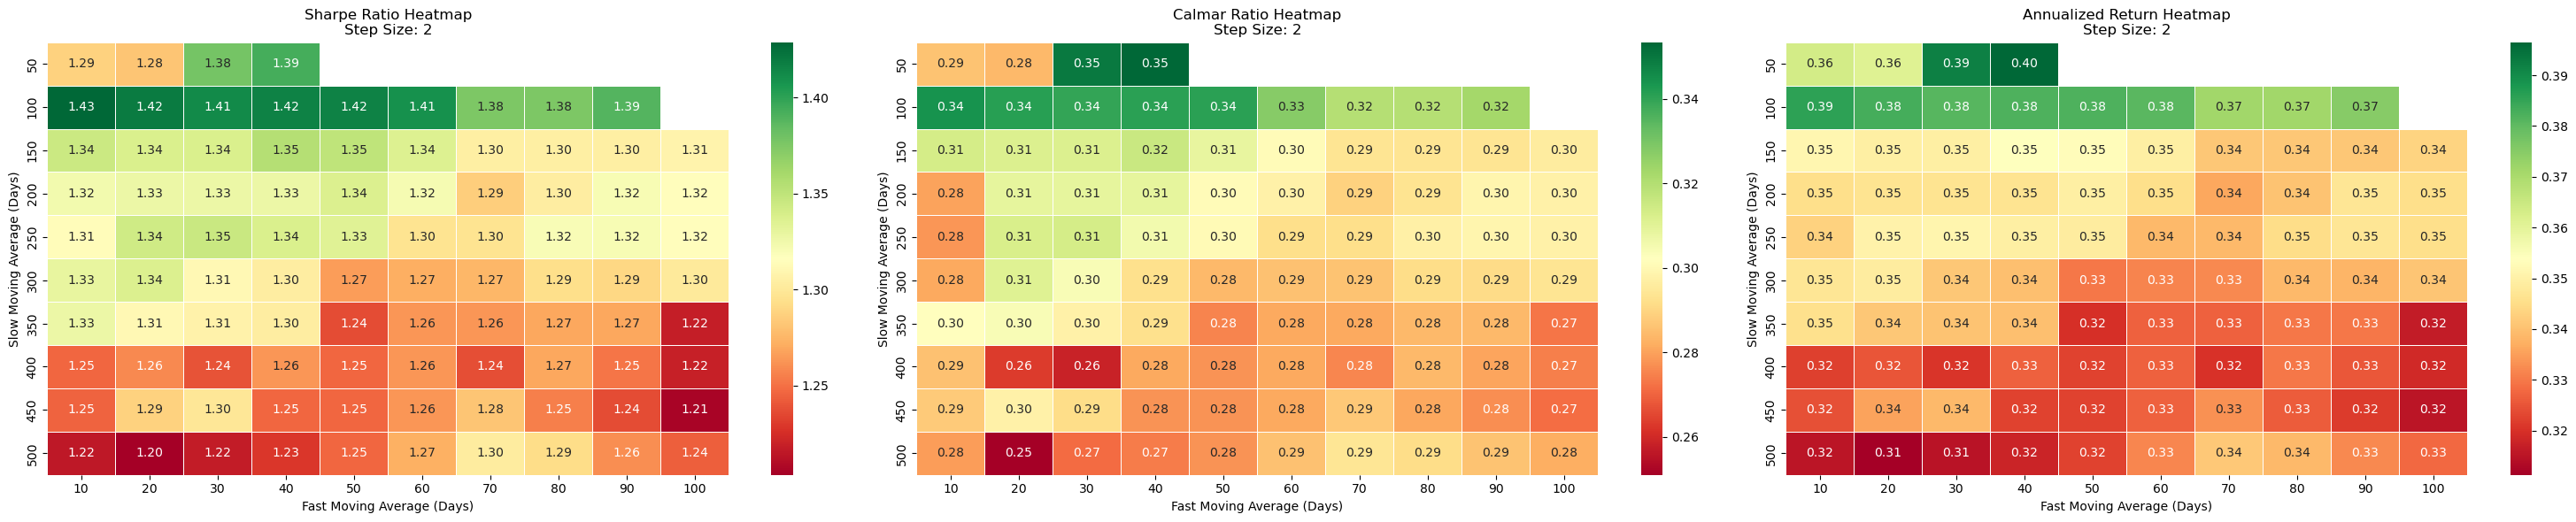

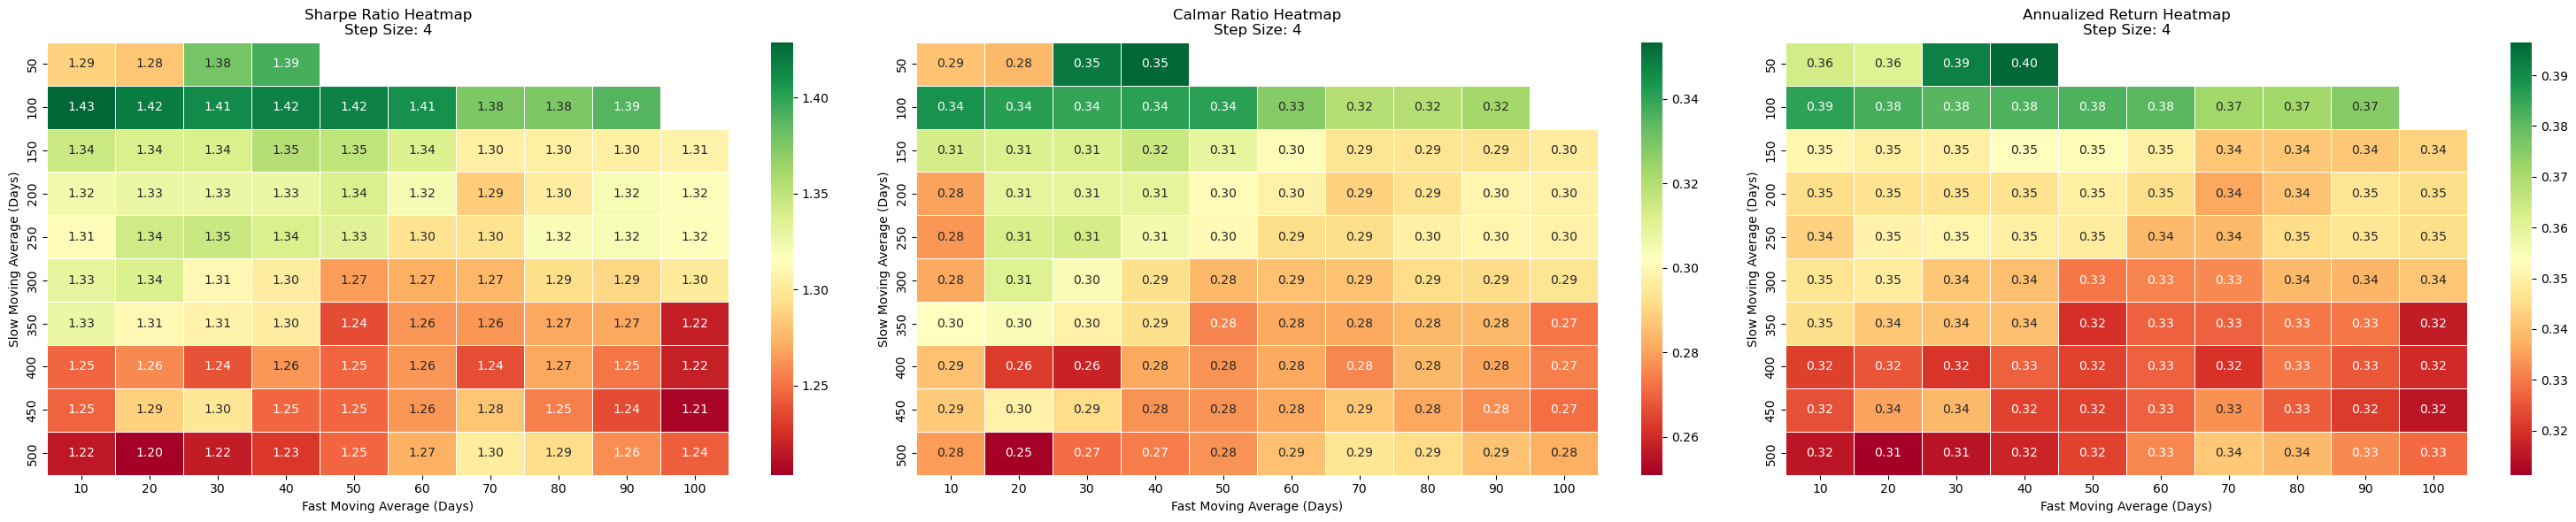

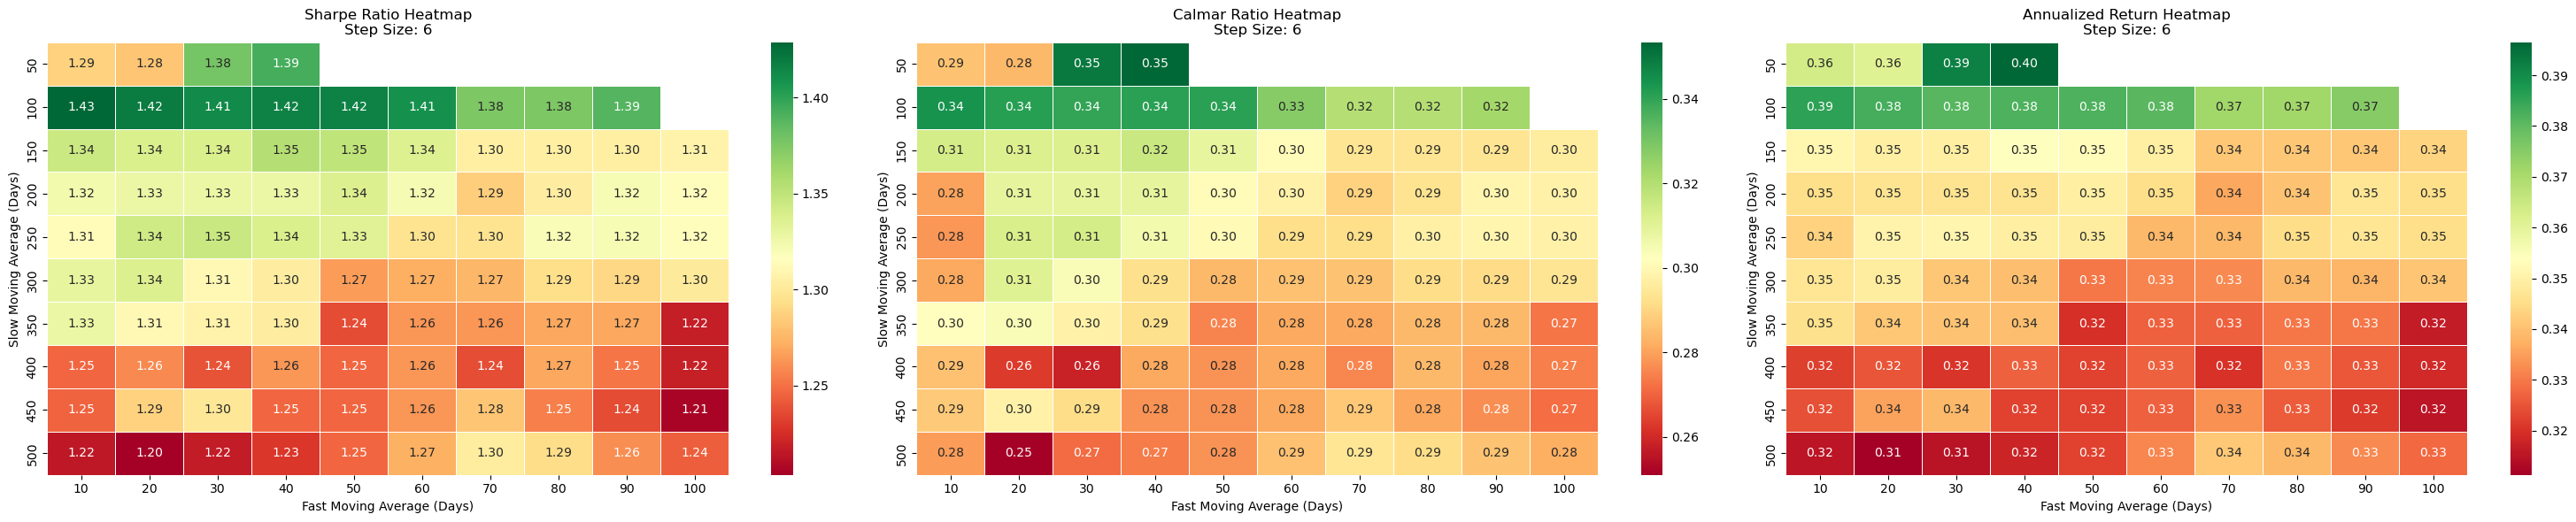

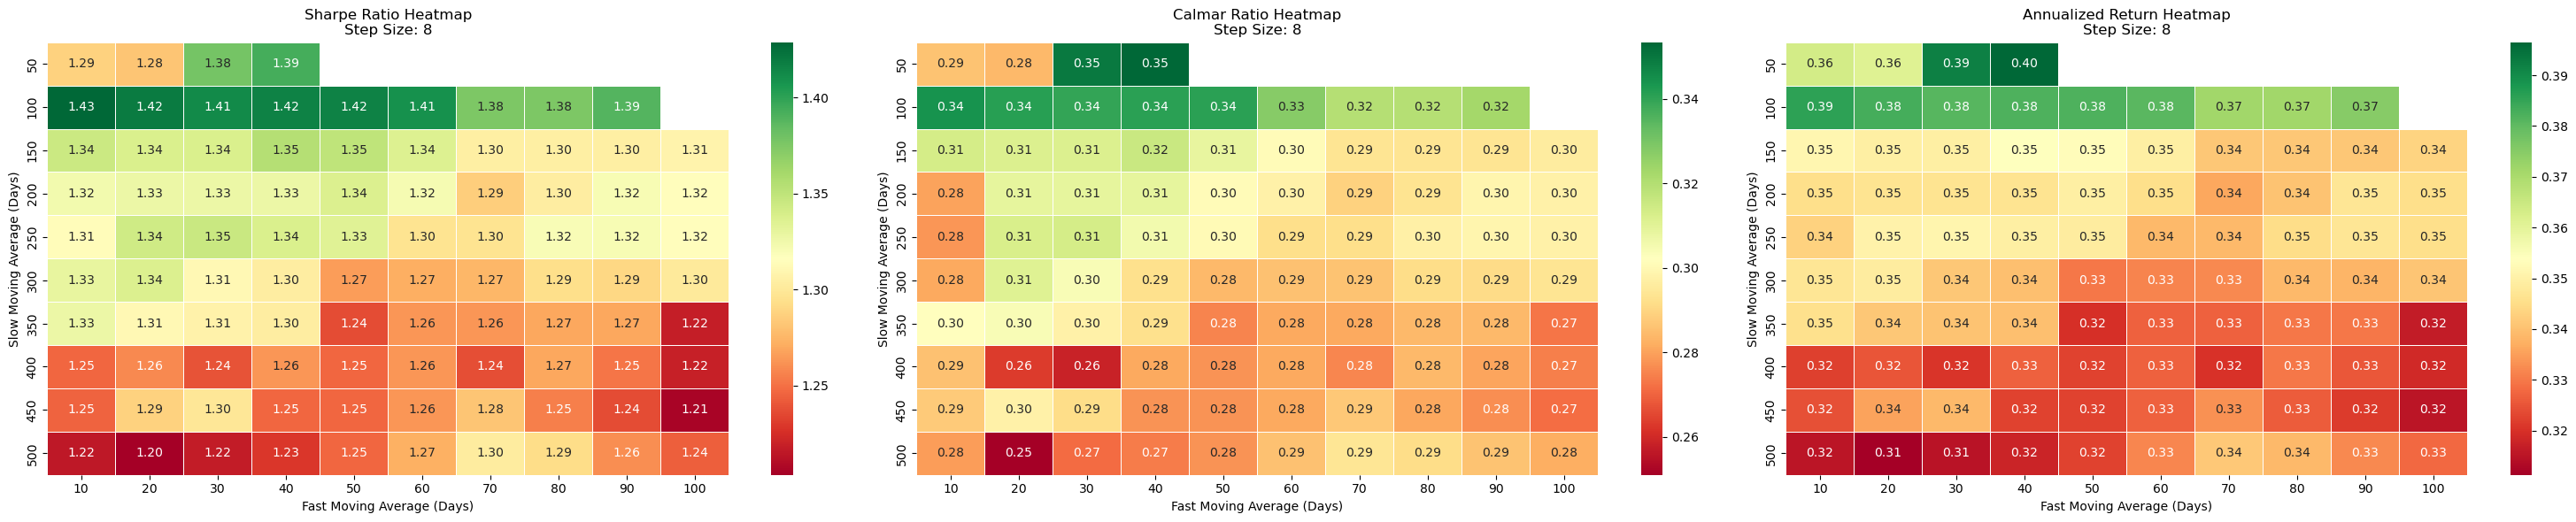

In [142]:
plot_moving_avg_crossover_performance_heatmap(df_performance_returns)

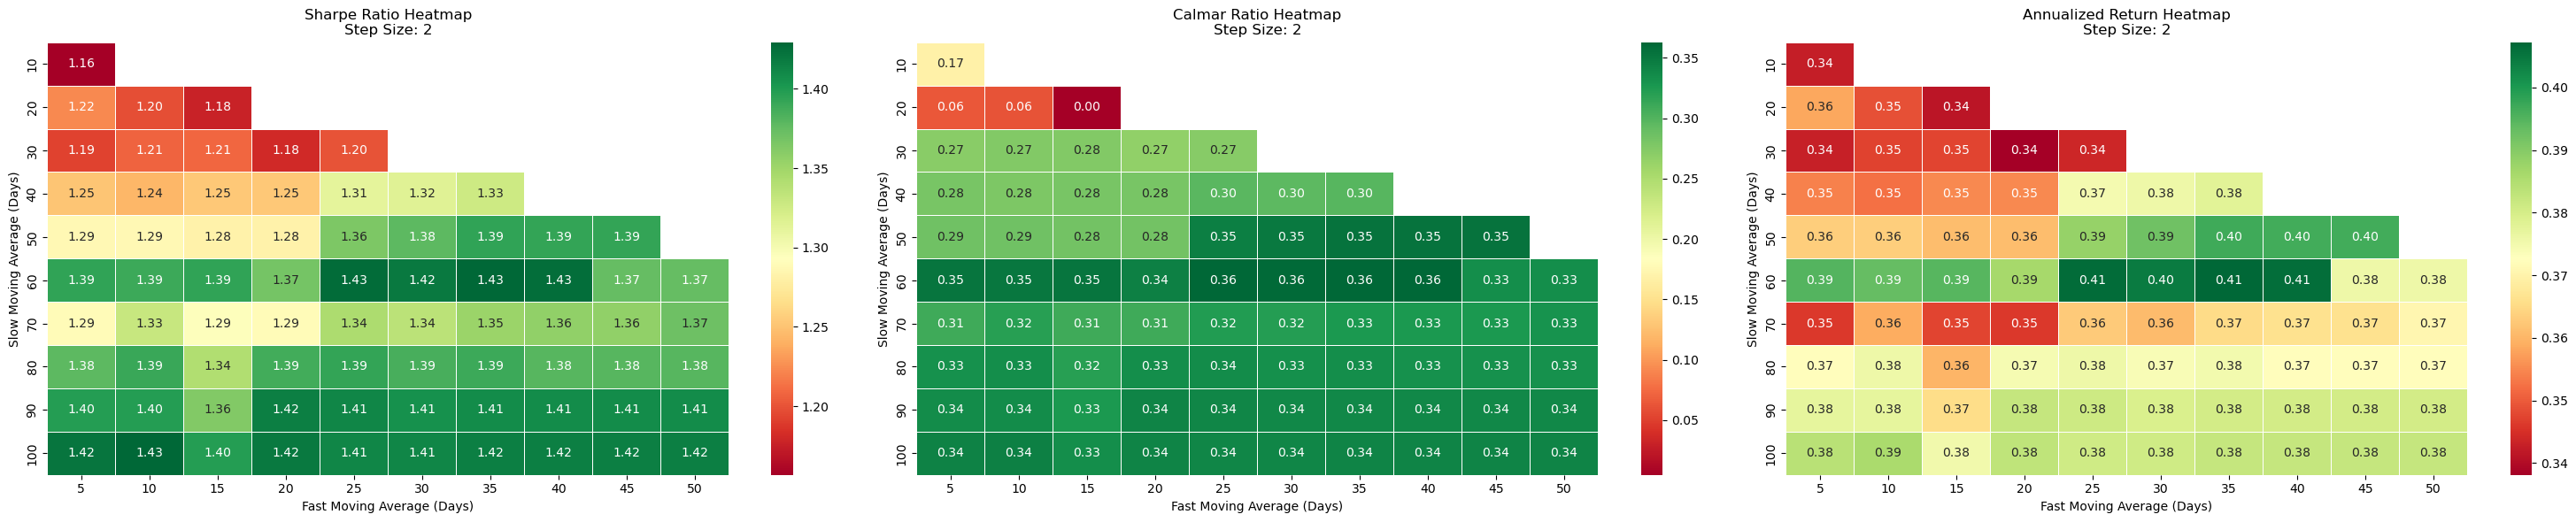

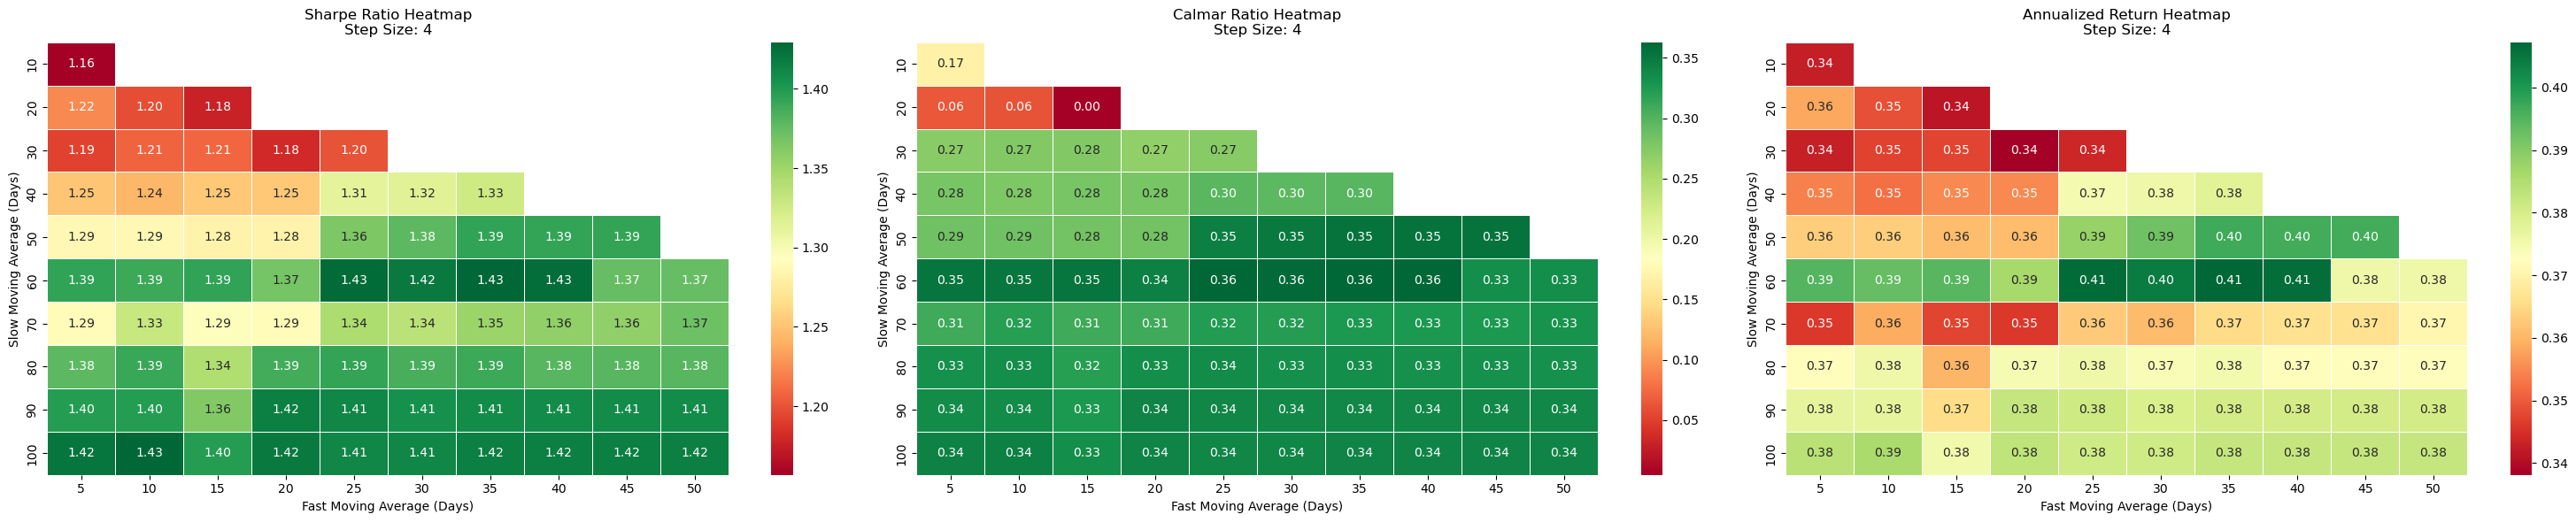

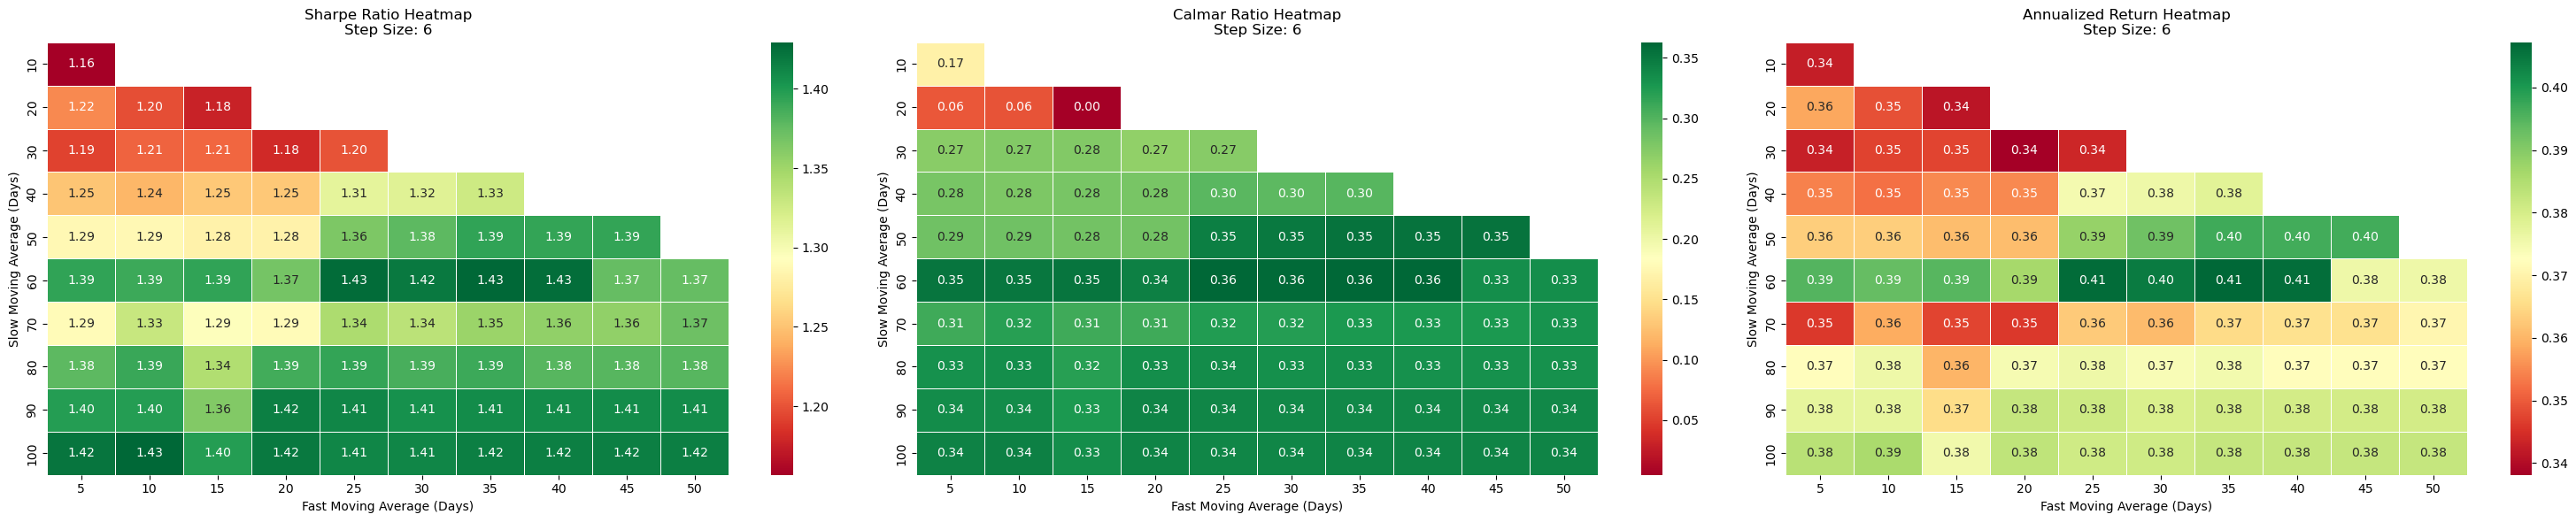

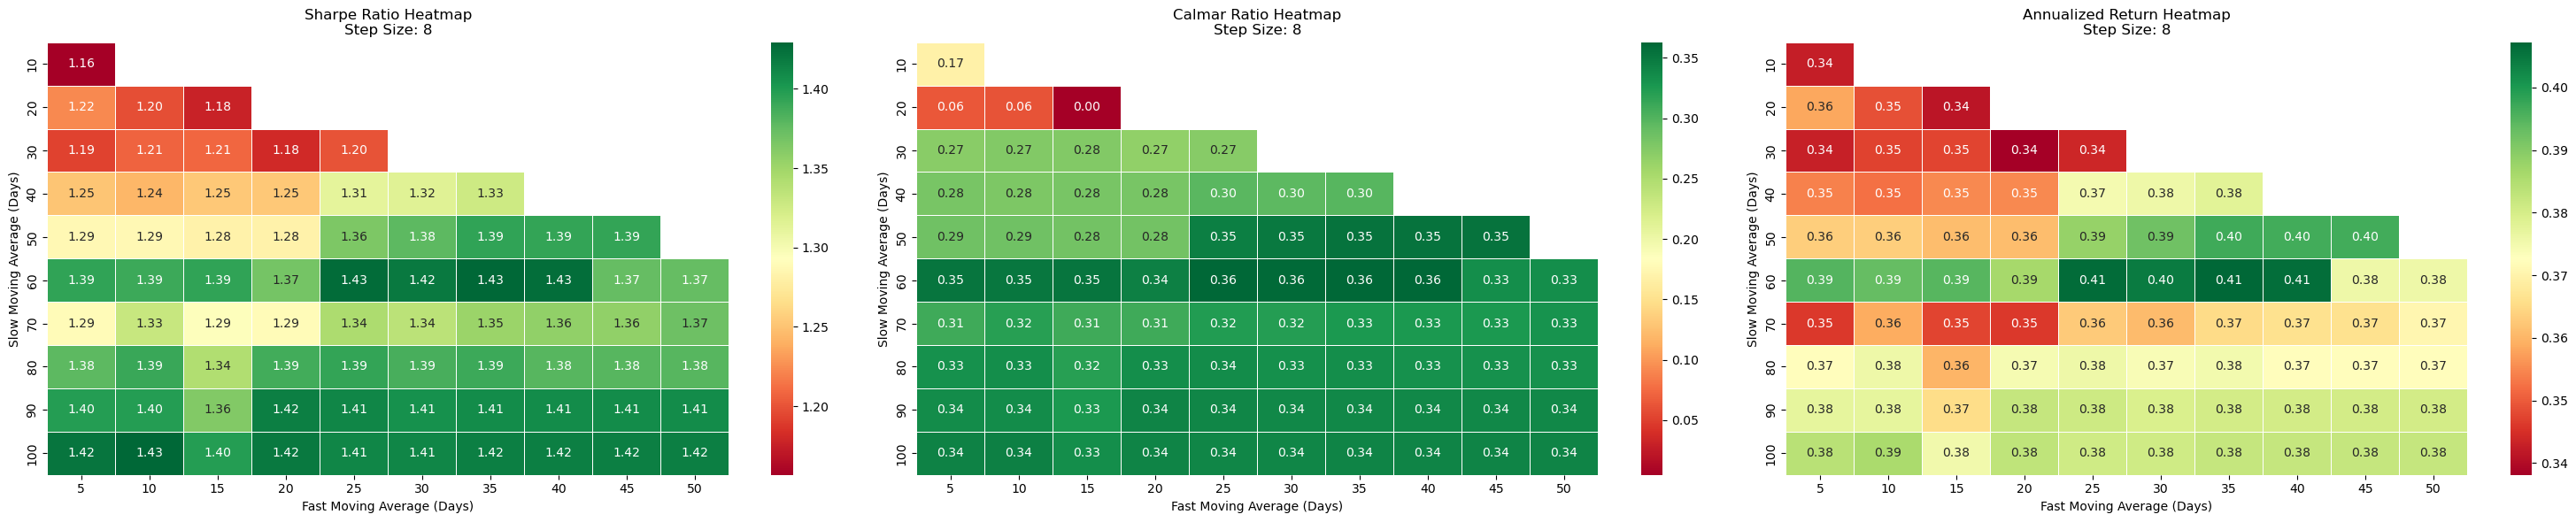

In [211]:
plot_moving_avg_crossover_performance_heatmap(df_performance_returns)

<Axes: xlabel='date'>

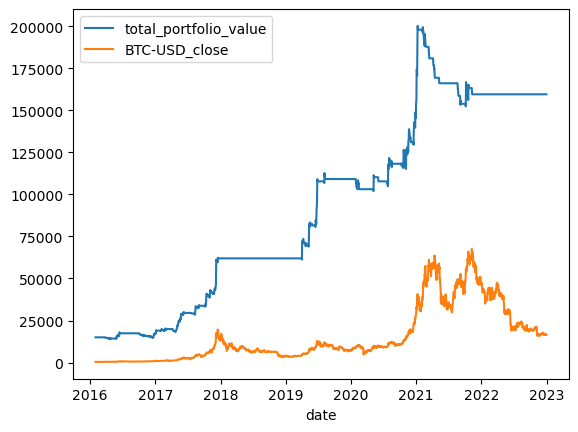

In [261]:
df[['total_portfolio_value','BTC-USD_close']].plot()

<Axes: xlabel='date'>

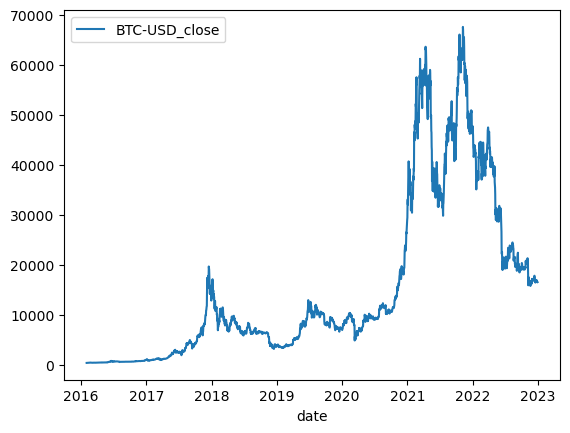

In [281]:
df[['BTC-USD_close']].plot()

<Axes: xlabel='date'>

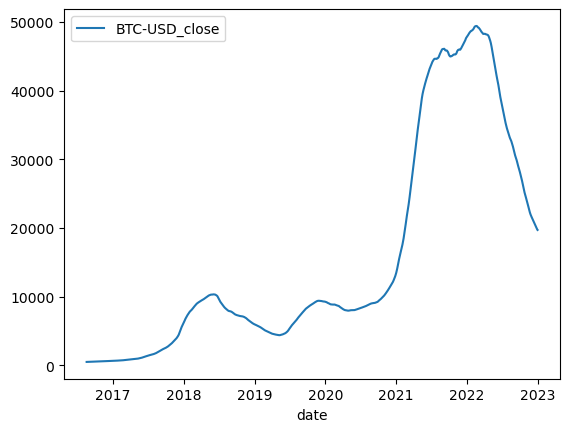

In [283]:
df[['BTC-USD_close']].rolling(window=200).mean().plot()

In [271]:
df[(df.index > pd.Timestamp('2021-01-01').date()) & (df.index < pd.Timestamp('2021-12-31').date()) & (df['BTC-USD_event'] != 'No Event')]

BTC-USD_20_donchian_lower_band_price_t_2  \
date                                                   
2021-01-02                                  18821.28   
2021-01-03                                  19166.65   
2021-01-04                                  19272.37   
2021-01-05                                  19444.60   
2021-01-06                                  21359.65   
2021-01-07                                  22729.40   
2021-01-08                                  22729.40   
2021-01-09                                  22729.40   
2021-01-10                                  22729.40   
2021-02-06                                  30407.13   
2021-02-07                                  30407.13   
2021-02-08                                  30407.13   
2021-02-09                                  30407.13   
2021-02-10                                  30407.13   
2021-02-11                                  30407.13   
2021-02-12                                  30407.13   
2021-02-13                                  30407.13   
2021-02-15                                  30407.13   
2021-02-16                                  30407.13   
2021-02-17                                  30407.13   
2021-02-18                                  33137.74   
2021-02-19                                  33137.74   
2021-02-20                                  33137.74   
2021-02-21                                  33137.74   
2021-02-22                                  33533.19   
2021-02-23                                  35512.67   
2021-03-12                                  45231.75   
2021-03-13                                  45231.75   
2021-03-14                                  45231.75   
2021-03-15                                  45231.75   
2021-04-06                                  51325.01   
2021-04-07                                  51325.01   
2021-04-11                                  51325.01   
2021-04-12                                  51325.01   
2021-04-13                                  51325.01   
2021-04-14                                  51325.01   
2021-04-15                                  51325.01   
2021-05-09                                  49121.00   
2021-05-10                                  49121.00   
2021-08-21                                  38191.44   
2021-08-22                                  38191.44   
2021-08-24                                  38191.44   
2021-08-25                                  39722.41   
2021-09-04                                  44671.58   
2021-09-05                                  44671.58   
2021-09-06                                  44671.58   
2021-09-07                                  44671.58   
2021-09-08                                  44707.98   
2021-10-05                                  40719.60   
2021-10-06                                  40719.60   
2021-10-07                                  40719.60   
2021-10-08                                  40719.60   
2021-10-12                                  40719.60   
2021-10-13                                  41026.07   
2021-10-16                                  41026.07   
2021-10-17                                  41026.07   
2021-10-19                                  41026.07   
2021-10-20                                  41522.16   
2021-10-21                                  43824.43   
2021-10-22                                  47657.69   
2021-11-09                                  58455.47   
2021-11-10                                  58455.47   

            BTC-USD_20_donchian_upper_band_price_t_2  \
date                                                   
2021-01-02                                  28990.08   
2021-01-03                                  29412.84   
2021-01-04                                  32225.91   
2021-01-05                                  33080.66   
2021-01-06                                  33080.66   
2021-01-07                         